In [ ]:
from warp.jax_experimental.ffi import jax_callable, jax_kernel 
import jax.numpy as jnp
import jax
import warp as wp

@wp.kernel
def scale_kernel(a: wp.array(dtype=float),
                 s: wp.array(dtype=float),
                 output: wp.array(dtype=float)):
    tid = wp.tid()
    output[tid] = a[tid] * s[0]


jax_scale = jax_kernel(scale_kernel)

@jax.jit
def f(a, s):
    return jax_scale(a, s)  # ERROR: traced scalar argument

a = jnp.arange(10, dtype=jnp.float32)
s = jnp.array([2.0])

print(f(a, s))

KeyboardInterrupt: 

In [ ]:
from warp.jax_experimental.ffi import jax_callable, jax_kernel 
import jax.numpy as jnp
import jax
import warp as wp

@wp.kernel
def scale_kernel(a: wp.array(dtype=float),
                 s: float,  # scalar input
                 output: wp.array(dtype=float)):
    tid = wp.tid()
    output[tid] = a[tid] * s


jax_scale = jax_kernel(scale_kernel)

@jax.jit
def f():
    a = jnp.arange(10, dtype=jnp.float32)
    return jax_scale(a, 2.0)  # ok: constant scalar argument

print(f())

Warp 1.7.0.dev20250223 initialized:
   CUDA Toolkit 12.8, Driver 12.2
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA A40" (44 GiB, sm_86, mempool enabled)
     "cuda:1"   : "NVIDIA A40" (47 GiB, sm_86, mempool enabled)
     "cuda:2"   : "NVIDIA A40" (47 GiB, sm_86, mempool enabled)
     "cuda:3"   : "NVIDIA A40" (47 GiB, sm_86, mempool enabled)
     "cuda:4"   : "NVIDIA A40" (47 GiB, sm_86, mempool enabled)
     "cuda:5"   : "NVIDIA A40" (47 GiB, sm_86, mempool enabled)
     "cuda:6"   : "NVIDIA A40" (47 GiB, sm_86, mempool enabled)
     "cuda:7"   : "NVIDIA A40" (47 GiB, sm_86, mempool enabled)
   CUDA peer access:
     Supported fully (all-directional)
   Kernel cache:
     /home/haw027/.cache/warp/1.7.0.dev20250223
Module __main__ 7d593f8 load on device 'cuda:0' took 0.38 ms  (cached)
[Array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.], dtype=float32)]


In [ ]:
@wp.kernel
def scale_kernel(a: wp.array(dtype=float), s: float, output: wp.array(dtype=float)):
    tid = wp.tid()
    output[tid] = a[tid] * s

@wp.kernel
def scale_vec_kernel(a: wp.array(dtype=wp.vec2), s: float, output: wp.array(dtype=wp.vec2)):
    tid = wp.tid()
    output[tid] = a[tid] * s


# The Python function to call.
# Note the argument type annotations, just like Warp kernels.
def example_func(
    # inputs
    a: wp.array(dtype=float),
    b: wp.array(dtype=wp.vec2),
    s: float,
    # outputs
    c: wp.array(dtype=float),
    d: wp.array(dtype=wp.vec2),
):
    # launch multiple kernels
    wp.launch(scale_kernel, dim=a.shape, inputs=[a, s], outputs=[c])
    wp.launch(scale_vec_kernel, dim=b.shape, inputs=[b, s], outputs=[d])


jax_func = jax_callable(example_func, num_outputs=2)

@jax.jit
def f():
    # inputs
    a = jnp.arange(10, dtype=jnp.float32)
    b = jnp.arange(10, dtype=jnp.float32).reshape((5, 2))  # wp.vec2
    s = 2.0

    print("a: ", a)
    print("s: ", s)
    # output shapes
    output_dims = {"c": a.shape, "d": b.shape}

    c, d = jax_func(a, b, s, output_dims=output_dims)

    return c, d

r1, r2 = f()
print(r1)
print(r2)

a:  Traced<ShapedArray(float32[10])>with<DynamicJaxprTrace>
s:  2.0
Module __main__ 65c51f1 load on device 'cuda:0' took 337.48 ms  (compiled)
[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
[[ 0.  2.]
 [ 4.  6.]
 [ 8. 10.]
 [12. 14.]
 [16. 18.]]


In [ ]:
@wp.kernel
def scale_kernel(a: wp.array(dtype=float), s: wp.array(dtype=float), output: wp.array(dtype=float)):
    tid = wp.tid()
    output[tid] = a[tid] * s[0]

@wp.kernel
def scale_vec_kernel(a: wp.array(dtype=wp.vec2), s: wp.array(dtype=float), output: wp.array(dtype=wp.vec2)):
    tid = wp.tid()
    output[tid] = a[tid] * s[0]


# The Python function to call.
# Note the argument type annotations, just like Warp kernels.
def example_func(
    # inputs
    a: wp.array(dtype=float),
    b: wp.array(dtype=wp.vec2),
    s: wp.array(dtype=float),
    # outputs
    c: wp.array(dtype=float),
    d: wp.array(dtype=wp.vec2),
):
    # launch multiple kernels
    wp.launch(scale_kernel, dim=a.shape, inputs=[a, s], outputs=[c])
    wp.launch(scale_vec_kernel, dim=b.shape, inputs=[b, s], outputs=[d])


jax_func = jax_callable(example_func, num_outputs=2)

@jax.jit
def f():
    # inputs
    a = jnp.arange(10, dtype=jnp.float32)
    b = jnp.arange(10, dtype=jnp.float32).reshape((5, 2))  # wp.vec2
    s = jnp.array([2.0])
    print(s)
    print(s[0])

    # output shapes
    output_dims = {"c": a.shape, "d": b.shape}

    c, d = jax_func(a, b, s, output_dims=output_dims)

    return c, d

r1, r2 = f()
print(r1)
print(r2)

Traced<ShapedArray(float32[1])>with<DynamicJaxprTrace>
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace>
a:  Traced<ShapedArray(float32[10])>with<DynamicJaxprTrace>
s:  Traced<ShapedArray(float32[1])>with<DynamicJaxprTrace>
Module __main__ 2f5dbcd load on device 'cuda:0' took 324.24 ms  (compiled)
[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
[[ 0.  2.]
 [ 4.  6.]
 [ 8. 10.]
 [12. 14.]
 [16. 18.]]


# test warp step function

In [ ]:
import json
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = "platform"
from os.path import join
import trimesh
from b3d.chisight.gen3d.dataloading import (
    get_initial_state,
    load_trial,
)
import b3d.chisight.gen3d.settings as settings
from genjax import Pytree, pretty
import copy
pretty()

scenario = 'roll'
trial_name = 'pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_small_zone_0017'

hdf5_file_path = "/orcd/data/jbt/001/hlwang/data/lf0"
mesh_file_path = "/orcd/data/jbt/001/hlwang/data/all_flex_meshes/"
pred_file_path = "/orcd/data/jbt/001/hlwang/data/gt_correct.json"

with open(pred_file_path) as f:
    pred_file_all = json.load(f)
pred_file = pred_file_all[trial_name]

all_meshes = {}
for path, dirs, files in os.walk(mesh_file_path):
    for name in files + dirs:
        if name.endswith(".obj"):
            mesh = trimesh.load(os.path.join(path, name))
            all_meshes[name[:-4]] = mesh


hdf5_file_path = join(
    hdf5_file_path,
    scenario + "_all_movies",
    f"{trial_name}.hdf5",
)

(
    rgbds_original,
    seg_arr_original,
    object_ids,
    object_segmentation_colors,
    background_areas,
    camera_pose,

    gt_pos_array,
    gt_rot_array,
    gt_linvel_array,
    gt_angvel_array,
) = load_trial(hdf5_file_path, 15)

hyperparams = settings.hyperparams
physics_args = {
        "mu": Pytree.const(0.25),
        "restitution": Pytree.const(0.4),
        "fps": Pytree.const(100),
        "sim_substeps": Pytree.const(10),
        "g": Pytree.const(-9.80665),
    }
hyperparams["physics_args"] = physics_args

initial_state, hyperparams, renderer, state, previous_info = get_initial_state(
    pred_file,
    object_ids,
    object_segmentation_colors,
    all_meshes,
    seg_arr_original[0],
    rgbds_original[0],
    hyperparams,
)
initial_state

/home/hlwang/.conda/envs/b3dipe/lib/python3.12/site-packages/genjax/_src/generative_functions/distributions/distribution.py:445: UserWarning: You should supply a name argument to exact_density
  warnings.warn("You should supply a name argument to exact_density")
/home/hlwang/.conda/envs/b3dipe/lib/python3.12/site-packages/genjax/_src/generative_functions/distributions/distribution.py:445: UserWarning: You should supply a name argument to exact_density
  warnings.warn("You should supply a name argument to exact_density")


Warp 1.7.0 initialized:
   CUDA Toolkit 12.8, Driver 12.4
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA H100 80GB HBM3" (79 GiB, sm_90, mempool enabled)
   Kernel cache:
     /home/hlwang/.cache/warp/1.7.0
Module warp.sim.inertia 3bc41ce load on device 'cuda:0' took 1.72 ms  (cached)
Module warp.sim.collide e2dca21 load on device 'cuda:0' took 2.88 ms  (cached)


{'object_pose_1': Pose(position=Array([ 1.25      ,  0.        , -0.74991846], dtype=float32), quaternion=Array([-0., -0., -0.,  1.], dtype=float32)),
 'object_vel_1': Velocity(linvel=Array([0., 0., 0.], dtype=float32), angvel=Array([0., 0., 0.], dtype=float32)),
 'object_pose_3': Pose(position=Array([-0.625,  0.01 ,  0.   ], dtype=float32), quaternion=Array([-0.000000e+00,  1.000000e+00, -0.000000e+00, -4.371139e-08],      dtype=float32)),
 'object_vel_3': Velocity(linvel=Array([0., 0., 0.], dtype=float32), angvel=Array([0., 0., 0.], dtype=float32)),
 'object_pose_2': Pose(position=Array([-0.8202851,  1.1496917,  0.       ], dtype=float32), quaternion=Array([ 0.5580489 ,  0.6396817 ,  0.5146658 , -0.12044886], dtype=float32)),
 'object_vel_2': Velocity(linvel=Array([0., 0., 0.], dtype=float32), angvel=Array([0., 0., 0.], dtype=float32))}

In [ ]:
hyperparams

{'pose_kernel': GaussianVMFPoseDriftKernel(std=0.02, concentration=1000.0),
 'velocity_kernel': GaussianVMFVelocityDriftKernel(
   std=0.2,
   concentration=1000.0,
 ),
 'physics_args': {'mu': Const(val=0.25),
  'restitution': Const(val=0.4),
  'fps': Const(val=100),
  'sim_substeps': Const(val=10),
  'g': Const(val=-9.80665),
  'sim_dt': Const(val=0.001),
  'rigid_contact_max': Const(val=892),
  'shape_contact_pair_count': Const(val=3),
  'shape_ground_contact_pair_count': Const(val=2),
  'rigid_contact_margin': Const(val=0.1),
  'body_count': Const(val=3)},
 'meshes': {1: Mesh(vertices=[[ 0.10124761  0.          0.08123589]
   [ 0.10124761  0.         -0.24370718]
   [ 0.10124761  0.          0.24370718]
   [ 0.10124761  0.         -0.08123589]
   [ 0.10124761  0.01        0.08123589]
   [ 0.10124761  0.01       -0.24370718]
   [ 0.10124761  0.01        0.24370718]
   [ 0.10124761  0.01       -0.08123589]
   [ 0.10124761  0.00333333 -0.24370718]
   [ 0.10124761  0.00333333  0.24370718]
   [ 0.10124761  0.00666667 -0.24370718]
   [ 0.10124761  0.00666667  0.24370718]
   [-0.30374223  0.          0.08123589]
   [-0.30374223  0.         -0.24370718]
   [-0.30374223  0.          0.24370718]
   [-0.30374223  0.         -0.08123589]
   [-0.30374223  0.01        0.08123589]
   [-0.30374223  0.01       -0.24370718]
   [-0.30374223  0.01        0.24370718]
   [-0.30374223  0.01       -0.08123589]
   [-0.30374223  0.00333333  0.08123589]
   [-0.30374223  0.00333333 -0.24370718]
   [-0.30374223  0.00333333  0.24370718]
   [-0.30374223  0.00333333 -0.08123589]
   [-0.30374223  0.00666667  0.08123589]
   [-0.30374223  0.00666667 -0.24370718]
   [-0.30374223  0.00666667  0.24370718]
   [-0.30374223  0.00666667 -0.08123589]
   [ 0.30374223  0.          0.08123589]
   [ 0.30374223  0.         -0.24370718]
   [ 0.30374223  0.          0.24370718]
   [ 0.30374223  0.         -0.08123589]
   [ 0.30374223  0.01        0.08123589]
   [ 0.30374223  0.01       -0.24370718]
   [ 0.30374223  0.01        0.24370718]
   [ 0.30374223  0.01       -0.08123589]
   [ 0.30374223  0.00333333  0.08123589]
   [ 0.30374223  0.00333333 -0.24370718]
   [ 0.30374223  0.00333333  0.24370718]
   [ 0.30374223  0.00333333 -0.08123589]
   [ 0.30374223  0.00666667  0.08123589]
   [ 0.30374223  0.00666667 -0.24370718]
   [ 0.30374223  0.00666667  0.24370718]
   [ 0.30374223  0.00666667 -0.08123589]
   [-0.10124761  0.          0.08123589]
   [-0.10124761  0.         -0.24370718]
   [-0.10124761  0.          0.24370718]
   [-0.10124761  0.         -0.08123589]
   [-0.10124761  0.01        0.08123589]
   [-0.10124761  0.01       -0.24370718]
   [-0.10124761  0.01        0.24370718]
   [-0.10124761  0.01       -0.08123589]
   [-0.10124761  0.00333333 -0.24370718]
   [-0.10124761  0.00333333  0.24370718]
   [-0.10124761  0.00666667 -0.24370718]
   [-0.10124761  0.00666667  0.24370718]], faces=[[32  6 34]
   [ 4  6 32]
   [ 4 50  6]
   [35  4 32]
   [48 50  4]
   [48 18 50]
   [48 16 18]
   [ 7  4 35]
   [ 7 48  4]
   [33  7 35]
   [33  5  7]
   [51 16 48]
   [ 7 51 48]
   [ 5 51  7]
   [51 19 16]
   [ 5 49 51]
   [49 19 51]
   [49 17 19]
   [12 46 14]
   [44 46 12]
   [44  2 46]
   [15 44 12]
   [ 0  2 44]
   [ 0 30  2]
   [ 0 28 30]
   [47 44 15]
   [47  0 44]
   [13 47 15]
   [13 45 47]
   [ 3 28  0]
   [47  3  0]
   [45  3 47]
   [ 3 31 28]
   [45  1  3]
   [ 1 31  3]
   [ 1 29 31]
   [ 6 42 34]
   [11 42  6]
   [11 38 42]
   [50 11  6]
   [ 9 38 11]
   [ 9 30 38]
   [ 9  2 30]
   [55 11 50]
   [55  9 11]
   [18 55 50]
   [18 26 55]
   [53  2  9]
   [55 53  9]
   [26 53 55]
   [53 46  2]
   [26 22 53]
   [22 46 53]
   [22 14 46]
   [16 26 18]
   [24 26 16]
   [24 22 26]
   [19 24 16]
   [20 22 24]
   [20 14 22]
   [20 12 14]
   [27 24 19]
   [27 20 24]
   [17 27 19]
   [17 25 27]
   [23 12 20]
   [27 23 20]
   [25 23 27]
   [23 15 12]
   [25 21 23]
   [21 15 23]
   [21 13 15]
   [49 25 17]
   [54 25 49]
   [54 21 25]
   [ 5 54 49]
   [52 21 54]
   [52 13 21]
   [52 45 13]

In [ ]:
from b3d.physics.physics_utils import step

In [ ]:
print(f"prev pose: {previous_info["prev_state"]._body_q}")
print(f"prev velocities: {previous_info["prev_state"]._body_qd}")
stepped_model, stepped_state = step(previous_info["prev_model"], previous_info["prev_state"], hyperparams["physics_args"])
print(f"stepped pose: {stepped_state._body_q}")
print(f"stepped velocities: {stepped_state._body_qd}")

prev pose: Pose(position=Array([[ 1.25      ,  0.        , -0.74991846],
       [-0.625     ,  0.01      ,  0.        ],
       [-0.8202851 ,  1.1496917 ,  0.        ]], dtype=float32), quaternion=Array([[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         1.00000000e+00],
       [-0.00000000e+00,  1.00000000e+00, -0.00000000e+00,
        -4.37113883e-08],
       [ 5.58048904e-01,  6.39681697e-01,  5.14665782e-01,
        -1.20448865e-01]], dtype=float32))
prev velocities: Velocity(linvel=Array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32), angvel=Array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32))
body_q inside step: [[ 1.25000000e+00  0.00000000e+00 -7.49918461e-01 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00  1.00000000e+00]
 [-6.25000000e-01  9.99999978e-03  0.00000000e+00 -0.00000000e+00
   1.00000000e+00 -0.00000000e+00 -4.37113883e-08]
 [-8.20285082e-01  1.14969170e+00  0.00000000e+00  5.58048904e-01
   6.396816

In [ ]:
sim_time = 0.0
for i in range(250):
    print(f"step: {i}")
    print(f"prev pose: {previous_info["prev_state"]._body_q}")
    print(f"prev velocities: {previous_info["prev_state"]._body_qd}")
    stepped_model, stepped_state = step(previous_info["prev_model"], previous_info["prev_state"], hyperparams["physics_args"])
    print(f"stepped pose: {stepped_state._body_q}")
    print(f"stepped velocities: {stepped_state._body_qd}")
    previous_info["prev_state"].update_attributes(_body_q=stepped_state._body_q, _body_qd=stepped_state._body_qd)
    previous_info["prev_model"] = stepped_model
    # print(previous_info["prev_state"]._body_q, previous_info["prev_state"]._body_qd)
    stepped_state_copy = copy.deepcopy(stepped_state)
    stepped_state_copy.from_pos_quat()
    state.body_q = stepped_state_copy._body_q
    state.body_qd = stepped_state_copy._body_qd
    renderer.begin_frame(sim_time)
    renderer.render(state)
    renderer.end_frame()
    sim_time += 1/100
renderer.save()

step: 0
prev pose: Pose(position=Array([[ 1.25      ,  0.        , -0.74991846],
       [-0.625     ,  0.01      ,  0.        ],
       [-0.8202851 ,  1.1496917 ,  0.        ]], dtype=float32), quaternion=Array([[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         1.00000000e+00],
       [-0.00000000e+00,  1.00000000e+00, -0.00000000e+00,
        -4.37113883e-08],
       [ 5.58048904e-01,  6.39681697e-01,  5.14665782e-01,
        -1.20448865e-01]], dtype=float32))
prev velocities: Velocity(linvel=Array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32), angvel=Array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32))
body_q inside step: [[ 1.25000000e+00  0.00000000e+00 -7.49918461e-01 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00  1.00000000e+00]
 [-6.25000000e-01  9.99999978e-03  0.00000000e+00 -0.00000000e+00
   1.00000000e+00 -0.00000000e+00 -4.37113883e-08]
 [-8.20285082e-01  1.14969170e+00  0.00000000e+00  5.58048904e-01
   

True

# test warp combined with genjax trace and inference

In [1]:
import json
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = "platform"
from os.path import join
import copy
import matplotlib.pyplot as plt
import numpy as np

import b3d
import b3d.chisight.dense.dense_model
import b3d.chisight.dense.likelihoods.laplace_likelihood
import b3d.chisight.gen3d.inference.inference as inference
import b3d.chisight.gen3d.settings as settings
import jax
import jax.numpy as jnp
import trimesh
from b3d.chisight.gen3d.dataloading import (
    get_initial_state,
    load_trial,
    resize_rgbds_and_get_masks,
)
from genjax import Pytree, pretty
pretty()

def foreground_background(depth_map, area, val):
    zero_depth_map = jnp.full(depth_map.shape, val)
    zero_depth_map = zero_depth_map.at[area].set(depth_map[area])
    return zero_depth_map

START_T = 0
near_plane = 0.1
far_plane = 100.0
im_width = 350
im_height = 350
width = 1024
height = 1024
num_particles = 10

hdf5_file_path = "/orcd/data/jbt/001/hlwang/data/lf0"
mesh_file_path = "/orcd/data/jbt/001/hlwang/data/all_flex_meshes/"
pred_file_path = "/orcd/data/jbt/001/hlwang/data/gt_correct.json"
scenario = 'roll'
trial_name = 'pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_small_zone_0017'

with open(pred_file_path) as f:
    pred_file_all = json.load(f)
pred_file = pred_file_all[trial_name]

all_meshes = {}
for path, dirs, files in os.walk(mesh_file_path):
    for name in files + dirs:
        if name.endswith(".obj"):
            mesh = trimesh.load(os.path.join(path, name))
            all_meshes[name[:-4]] = mesh

scaling_factor = im_height / height
vfov = 54.43222 / 180.0 * jnp.pi
tan_half_vfov = jnp.tan(vfov / 2.0)
tan_half_hfov = tan_half_vfov * width / float(height)
fx = width / 2.0 / tan_half_hfov
fy = height / 2.0 / tan_half_vfov

renderer = b3d.renderer.renderer_original.RendererOriginal(
    width * scaling_factor,
    height * scaling_factor,
    fx * scaling_factor,
    fy * scaling_factor,
    (width / 2) * scaling_factor,
    (height / 2) * scaling_factor,
    near_plane,
    far_plane,
)

b3d.reload(b3d.chisight.dense.likelihoods.laplace_likelihood)
likelihood_func = b3d.chisight.dense.likelihoods.laplace_likelihood.likelihood_func

b3d.reload(b3d.chisight.dense.dense_model)
dynamic_object_generative_model, viz_trace = (
    b3d.chisight.dense.dense_model.make_dense_multiobject_dynamics_model(
        renderer, likelihood_func
    )
)
# importance_vmap = jax.vmap(dynamic_object_generative_model.importance, in_axes=(0, None, None))
# importance_jit = jax.jit(importance_vmap)
importance_jit = jax.jit(dynamic_object_generative_model.importance)
# importance_vmap = jax.vmap(importance_jit, in_axes=(0, None, None))

likelihood_args = {
    "fx": renderer.fx,
    "fy": renderer.fy,
    "cx": renderer.cx,
    "cy": renderer.cy,
    "color_noise_variance": 1.0,
    "depth_noise_variance": 0.01,
    "outlier_probability": 0.1,
    "image_width": Pytree.const(renderer.width),
    "image_height": Pytree.const(renderer.height),
    "masked": Pytree.const(True),
    "check_interp": Pytree.const(False),
    "num_mc_sample": Pytree.const(500),
    "interp_penalty": Pytree.const(1e5),
}

physics_args = {
    "mu": Pytree.const(0.25),
    "restitution": Pytree.const(0.4),
    "fps": Pytree.const(100),
    "sim_substeps": Pytree.const(10),
    "g": Pytree.const(-9.80665),
}

inference_hyperparams = b3d.chisight.gen3d.settings.inference_hyperparams

hdf5_file_path = join(
    hdf5_file_path,
    scenario + "_all_movies",
    f"{trial_name}.hdf5",
)

(
    rgbds_original,
    seg_arr_original,
    object_ids,
    object_segmentation_colors,
    background_areas,
    camera_pose,
    
    gt_pos_array,
    gt_rot_array,
    gt_linvel_array,
    gt_angvel_array,
) = load_trial(hdf5_file_path, 250)

hyperparams = settings.hyperparams
hyperparams["camera_pose"] = camera_pose
hyperparams["likelihood_args"] = likelihood_args
hyperparams["physics_args"] = physics_args

initial_state, hyperparams, renderer, state, initial_warp_info = get_initial_state(
    pred_file,
    object_ids,
    object_segmentation_colors,
    all_meshes,
    seg_arr_original[START_T],
    rgbds_original[START_T],
    hyperparams,
)

rgbds, all_areas, background_areas = resize_rgbds_and_get_masks(
    rgbds_original, seg_arr_original, background_areas, im_height, im_width
)
hyperparams["background"] = jnp.asarray(
    [
        foreground_background(rgbds[t], background_areas[t], jnp.inf)
        for t in range(rgbds.shape[0])
    ]
)
initial_state

/home/hlwang/.conda/envs/b3dipe/lib/python3.12/site-packages/genjax/_src/generative_functions/distributions/distribution.py:445: UserWarning: You should supply a name argument to exact_density
  warnings.warn("You should supply a name argument to exact_density")
/home/hlwang/.conda/envs/b3dipe/lib/python3.12/site-packages/genjax/_src/generative_functions/distributions/distribution.py:445: UserWarning: You should supply a name argument to exact_density
  warnings.warn("You should supply a name argument to exact_density")
/home/hlwang/.conda/envs/b3dipe/lib/python3.12/site-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Warp 1.7.0 initialized:
   CUDA Toolkit 12.8, Driver 12.4
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA H100 80GB HBM3" (79 GiB, sm_90, mempool enabled)
   Kernel cache:
     /home/hlwang/.cache/warp/1.7.0
Module warp.sim.inertia 3bc41ce load on device 'cuda:0' took 1.41 ms  (cached)
Module warp.sim.collide e2dca21 load on device 'cuda:0' took 35.54 ms  (cached)


{'object_pose_1': Pose(position=Array([ 1.25      ,  0.        , -0.74991846], dtype=float32), quaternion=Array([-0., -0., -0.,  1.], dtype=float32)),
 'object_vel_1': Velocity(linvel=Array([0., 0., 0.], dtype=float32), angvel=Array([0., 0., 0.], dtype=float32)),
 'object_pose_3': Pose(position=Array([-0.625,  0.01 ,  0.   ], dtype=float32), quaternion=Array([-0.000000e+00,  1.000000e+00, -0.000000e+00, -4.371139e-08],      dtype=float32)),
 'object_vel_3': Velocity(linvel=Array([0., 0., 0.], dtype=float32), angvel=Array([0., 0., 0.], dtype=float32)),
 'object_pose_2': Pose(position=Array([-0.8202851,  1.1496917,  0.       ], dtype=float32), quaternion=Array([ 0.5580489 ,  0.6396817 ,  0.5146658 , -0.12044886], dtype=float32)),
 'object_vel_2': Velocity(linvel=Array([0., 0., 0.], dtype=float32), angvel=Array([0., 0., 0.], dtype=float32))}

In [2]:
initial_warp_info

{'prev_model': <b3d.physics.core.Model at 0x14de416c7a10>,
 'prev_state': <b3d.physics.core.State at 0x14de416c7b60>,
 't': -1}

In [3]:
# random_number = 42
# key = jax.random.PRNGKey(random_number)
# initializer_keys = jax.random.split(key, num_particles)
# init_particles, init_weights = inference.get_initial_particles(
#     initializer_keys,
#     importance_vmap,
#     hyperparams,
#     initial_state,
#     initial_warp_info,
#     foreground_background(rgbds[START_T], all_areas[START_T], 0.0),
# )

In [4]:
random_number = 42
key = jax.random.PRNGKey(random_number)
trace = inference.get_initial_trace(
        key,
        importance_jit,
        hyperparams,
        initial_state,
        initial_warp_info,
        foreground_background(rgbds[START_T], all_areas[START_T], 0.0),
    )
trace

Module b3d.physics.physics_utils 115c70c load on device 'cuda:0' took 1.74 ms  (cached)
prev pose: Pose(position=Array([[ 1.25      ,  0.        , -0.74991846],
       [-0.625     ,  0.01      ,  0.        ],
       [-0.8202851 ,  1.1496917 ,  0.        ]], dtype=float32), quaternion=Array([[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         1.00000000e+00],
       [-0.00000000e+00,  1.00000000e+00, -0.00000000e+00,
        -4.37113883e-08],
       [ 5.58048904e-01,  6.39681697e-01,  5.14665782e-01,
        -1.20448865e-01]], dtype=float32))
prev velocities: Velocity(linvel=Array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32), angvel=Array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32))
stepped pose: Pose(position=Array([[ 1.25      ,  0.        , -0.74991846],
       [-0.625     ,  0.01      ,  0.        ],
       [-0.8202851 ,  1.1496917 ,  0.        ]], dtype=float32), quaternion=Array([[-0.00000000e+00, -0.00000000e+00, -

/home/hlwang/.conda/envs/b3dipe/lib/python3.12/site-packages/treescope/_internal/arrayviz_impl.py:403: RuntimeWarning: Mean of empty slice
  second_moment = np.nanmean(


StaticTrace(
  gen_fn=StaticGenerativeFunction(
    source=Closure(
      dyn_args=(),
      fn=<function make_dense_multiobject_dynamics_model.<locals>.dense_multiobject_model at 0x14de653ae3e0>,  # Defined at line 48 of /orcd/home/002/hlwang/code/b3d/src/b3d/chisight/dense/dense_model.py
    ),
  ),
  args=(
    {'background': <jax.Array float32(250, 350, 350, 4)- too large to summarize.>, 'camera_pose': Pose(position=Array([ 1.6369833,  2.7457173, -1.8490524], dtype=float32), quaternion=Array([-0.32376173, -0.38056213,  0.8541322 , -0.14425336], dtype=float32)), 'likelihood_args': {'check_interp': Const(val=False), 'color_noise_variance': <jax.Array(1., dtype=float32, weak_type=True)>, 'cx': <jax.Array(175., dtype=float32, weak_type=True)>, 'cy': <jax.Array(175., dtype=float32, weak_type=True)>, 'depth_noise_variance': <jax.Array(0.01, dtype=float32, weak_type=True)>, 'fx': <jax.Array(340.2778, dtype=float32, weak_type=True)>, 'fy': <jax.Array(340.2778, dtype=float32, weak_type=True)>, 'image_height': Const(val=350), 'image_width': Const(val=350), 'interp_penalty': Const(val=100000.0), 'masked': Const(val=True), 'num_mc_sample': Const(val=500), 'outlier_probability': <jax.Array(0.1, dtype=float32, weak_type=True)>}, 'meshes': {1: <b3d.mesh.Mesh object at 0x14ddcc353b00>, 2: <b3d.mesh.Mesh object at 0x14ddcc0d77a0>, 3: <b3d.mesh.Mesh object at 0x14dfd44a56a0>}, 'object_ids': Const(val=[1, 3, 2]), 'physics_args': {'body_count': Const(val=3), 'fps': Const(val=100), 'g': Const(val=-9.80665), 'mu': Const(val=0.25), 'restitution': Const(val=0.4), 'rigid_contact_margin': Const(val=0.1), 'rigid_contact_max': Const(val=640), 'shape_contact_pair_count': Const(val=2), 'shape_ground_contact_pair_count': Const(val=1), 'sim_dt': Const(val=0.001), 'sim_substeps': Const(val=10)}, 'pose_kernel': GaussianVMFPoseDriftKernel(std=0.02, concentration=1000.0), 'velocity_kernel': GaussianVMFVelocityDriftKernel(std=0.2, concentration=1000.0)},
    {'object_pose_1': Pose(position=Array([ 1.25      ,  0.        , -0.74991846], dtype=float32), quaternion=Array([-0., -0., -0.,  1.], dtype=float32)), 'object_pose_2': Pose(position=Array([-0.8202851,  1.1496917,  0.       ], dtype=float32), quaternion=Array([ 0.5580489 ,  0.6396817 ,  0.5146658 , -0.12044886], dtype=float32)), 'object_pose_3': Pose(position=Array([-0.625,  0.01 ,  0.   ], dtype=float32), quaternion=Array([-0.000000e+00,  1.000000e+00, -0.000000e+00, -4.371139e-08],      dtype=float32)), 'object_vel_1': Velocity(linvel=Array([0., 0., 0.], dtype=float32), angvel=Array([0., 0., 0.], dtype=float32)), 'object_vel_2': Velocity(linvel=Array([0., 0., 0.], dtype=float32), angvel=Array([0., 0., 0.], dtype=float32)), 'object_vel_3': Velocity(linvel=Array([0., 0., 0.], dtype=float32), angvel=Array([0., 0., 0.], dtype=float32)), 'prev_model': <b3d.physics.core.Model object at 0x14ddcc3c32f0>, 'prev_state': <b3d.physics.core.State object at 0x14ddc437b290>, 't': <jax.Array(-1, dtype=int32, weak_type=True)>},
  ),
  retval={
    'likelihood_args': {'check_interp': Const(val=False), 'color_noise_variance': <jax.Array(1., dtype=float32, weak_type=True)>, 'cx': <jax.Array(175., dtype=float32, weak_type=True)>, 'cy': <jax.Array(175., dtype=float32, weak_type=True)>, 'depth_noise_variance': <jax.Array(0.01, dtype=float32, weak_type=True)>, 'fx': <jax.Array(340.2778, dtype=float32, weak_type=True)>, 'fy': <jax.Array(340.2778, dtype=float32, weak_type=True)>, 'image_height': Const(val=350), 'image_width': Const(val=350), 'interp_penalty': Const(val=100000.0), 'latent_rgbd': <jax.Array float32(350, 350, 4) ≈0.18 ±0.64 [≥0.0, ≤4.1] zero:422_344 nonzero:67_656>, 'masked': Const(val=True), 'num_mc_sample': Const(val=500), 'outlier_probability': <jax.Array(0.1, dtype=float32, weak_type=True)>, 'rasterize_results': <jax.Array float32(350, 350, 4) ≈5.7 ±3.5e+01 [≥0.0, ≤6.2e+02] zero:422_344 nonzero:67_656>, 'scene_mesh': [<b3d.mesh.Mesh object at 0x14ddc437b860>, <b3d.mesh.Mesh object at 0x14ddcc3149e0>, <b3d.mesh.M

In [5]:
T = 0
print(f"step {T}:")
if T == 0:
    xyz = False
    infer_vel = False
else:
    xyz = True
    infer_vel = True

relevant_objects = [2]

particle, _ = inference.inference_step(
                key,
                trace,
                foreground_background(rgbds[T], all_areas[T], 0.0),
                inference_hyperparams,
                [Pytree.const(f"object_pose_{o_id}") for o_id in relevant_objects],
                xyz,
                infer_vel,
            )

step 0:
prev pose: Pose(position=Array([[ 1.25      ,  0.        , -0.74991846],
       [-0.625     ,  0.01      ,  0.        ],
       [-0.8202851 ,  1.1496917 ,  0.        ]], dtype=float32), quaternion=Array([[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         1.00000000e+00],
       [-0.00000000e+00,  1.00000000e+00, -0.00000000e+00,
        -4.37113883e-08],
       [ 5.58048904e-01,  6.39681697e-01,  5.14665782e-01,
        -1.20448865e-01]], dtype=float32))
prev velocities: Velocity(linvel=Array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32), angvel=Array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32))
stepped pose: Pose(position=Array([[ 1.25      ,  0.        , -0.74991846],
       [-0.625     ,  0.01      ,  0.        ],
       [-0.8202851 ,  1.1496917 ,  0.        ]], dtype=float32), quaternion=Array([[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         1.00000000e+00],
       [-0.00000000e+00,  1.00000000e+

In [5]:
T = 0
print(f"step {T}:")
if T == 0:
    xyz = False
    infer_vel = False
else:
    xyz = True
    infer_vel = True

relevant_objects = [2]
initializer_keys = jax.random.split(key, num_particles)
particles = []
for i, initializer_key in enumerate(initializer_keys):
    print(i)
    particle, _ = inference.inference_step(
                initializer_key,
                trace,
                foreground_background(rgbds[T], all_areas[T], 0.0),
                inference_hyperparams,
                [Pytree.const(f"object_pose_{o_id}") for o_id in relevant_objects],
                xyz,
                infer_vel,
                k=1
            )
    particles.append(particle)


step 0:
0
Traceback (most recent call last):
  File "/home/hlwang/.conda/envs/b3dipe/lib/python3.12/site-packages/warp/jax_experimental/ffi.py", line 563, in ffi_callback
    self.func(*arg_list)
  File "/orcd/home/002/hlwang/code/b3d/src/b3d/physics/physics_utils.py", line 735, in simulate
    wp.launch(
  File "/home/hlwang/.conda/envs/b3dipe/lib/python3.12/site-packages/warp/context.py", line 5732, in launch
    pack_args(fwd_args, params)
  File "/home/hlwang/.conda/envs/b3dipe/lib/python3.12/site-packages/warp/context.py", line 5699, in pack_args
    params.append(pack_arg(kernel, arg_type, arg_name, a, device, adjoint))
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hlwang/.conda/envs/b3dipe/lib/python3.12/site-packages/warp/context.py", line 5332, in pack_arg
    raise RuntimeError(
RuntimeError: Error launching kernel 'eval_rigid_contacts', argument 'body_q' expects an array with 1 dimension(s) but the passed array has 2 dimension(s).



E0716 11:23:34.191669  578070 pjrt_stream_executor_client.cc:3077] Execution of replica 0 failed: INTERNAL: Failed to capture gpu graph: FFI callback error: RuntimeError: Error launching kernel 'eval_rigid_contacts', argument 'body_q' expects an array with 1 dimension(s) but the passed array has 2 dimension(s).


XlaRuntimeError: INTERNAL: Failed to capture gpu graph: FFI callback error: RuntimeError: Error launching kernel 'eval_rigid_contacts', argument 'body_q' expects an array with 1 dimension(s) but the passed array has 2 dimension(s).

In [ ]:
linvel_mags = []
angvel_mags = []
linvel_dirs = []
angvel_dirs = []
for particle in particles:
    linvel_mags.append(particle.get_choices()['object_vel_1'].lin_vel_mag)
    linvel_mags.append(particle.get_choices()['object_vel_2'].lin_vel_mag)
    linvel_mags.append(particle.get_choices()['object_vel_3'].lin_vel_mag)
    angvel_mags.append(particle.get_choices()['object_vel_1'].ang_vel_mag)
    angvel_mags.append(particle.get_choices()['object_vel_1'].ang_vel_mag)
    angvel_mags.append(particle.get_choices()['object_vel_1'].ang_vel_mag)
    linvel_dirs.append(particle.get_choices()['object_vel_1'].lin_vel_dir)
    linvel_dirs.append(particle.get_choices()['object_vel_2'].lin_vel_dir)
    linvel_dirs.append(particle.get_choices()['object_vel_3'].lin_vel_dir)
    angvel_dirs.append(particle.get_choices()['object_vel_1'].ang_vel_dir)
    angvel_dirs.append(particle.get_choices()['object_vel_2'].ang_vel_dir)
    angvel_dirs.append(particle.get_choices()['object_vel_3'].ang_vel_dir)


(array([59., 51., 60., 41., 31., 24.,  8., 15.,  6.,  5.]),
 array([5.29037789e-03, 5.43569505e-01, 1.08184862e+00, 1.62012768e+00,
        2.15840673e+00, 2.69668603e+00, 3.23496509e+00, 3.77324414e+00,
        4.31152344e+00, 4.84980249e+00, 5.38808155e+00]),
 <BarContainer object of 10 artists>)

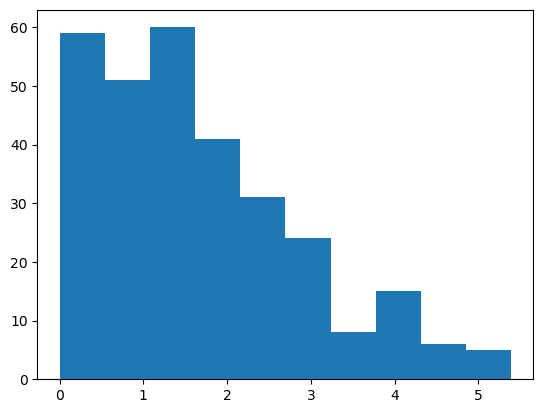

In [ ]:
plt.hist(linvel_mags)

(array([72., 57., 48., 30., 39., 12., 24.,  6.,  6.,  6.]),
 array([0.01572215, 0.52333283, 1.03094351, 1.53855419, 2.04616475,
        2.55377555, 3.06138611, 3.56899691, 4.0766077 , 4.58421803,
        5.09182882]),
 <BarContainer object of 10 artists>)

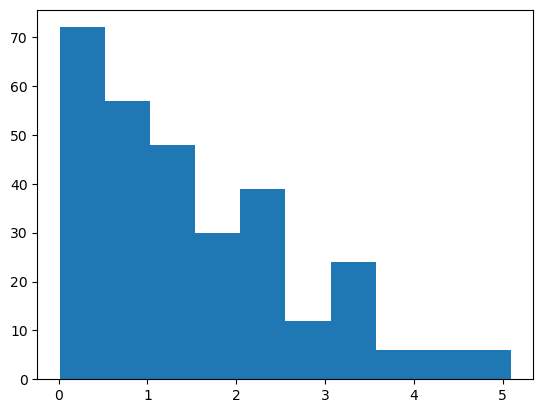

In [ ]:
plt.hist(angvel_mags)

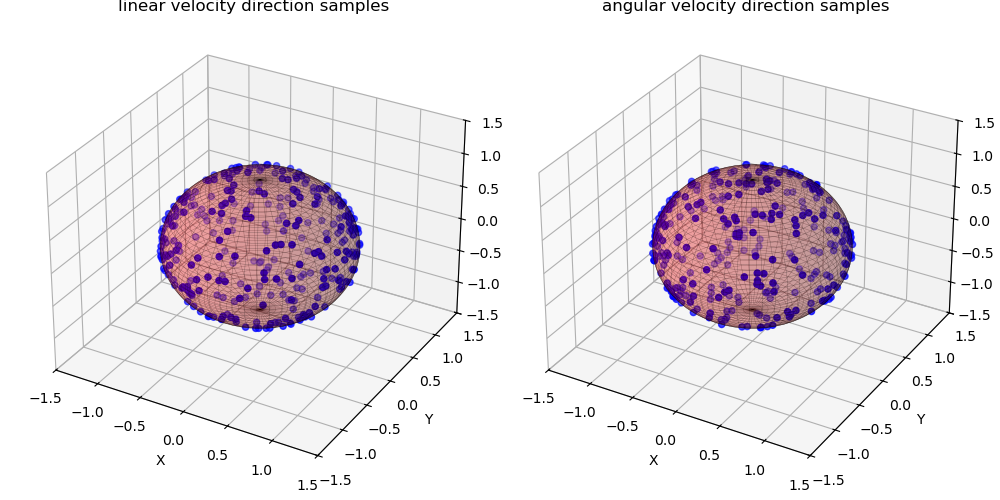

In [ ]:
%matplotlib ipympl
linvel_dirs_2d = jnp.stack(linvel_dirs)  # s
x1 = linvel_dirs_2d[:, 0]
y1 = linvel_dirs_2d[:, 1]
z1 = linvel_dirs_2d[:, 2]

angvel_dirs_2d = jnp.stack(angvel_dirs)  # s
x2 = angvel_dirs_2d[:, 0]
y2 = angvel_dirs_2d[:, 1]
z2 = angvel_dirs_2d[:, 2]

# Create a unit sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
xs = np.outer(np.cos(u), np.sin(v))
ys = np.outer(np.sin(u), np.sin(v))
zs = np.outer(np.ones_like(u), np.cos(v))

# Create figure and two 3D subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'projection': '3d'})

for ax, (x, y, z), title in zip(
    axes,
    [(x1, y1, z1), (x2, y2, z2)],
    ['linear velocity direction samples', 'angular velocity direction samples']
):
    # Scatter plot
    ax.scatter(x, y, z, color='blue', label='Data Points')
    # Unit sphere
    ax.plot_surface(xs, ys, zs, color='red', alpha=0.2, edgecolor='k', linewidth=0.3)
    
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([-1.5, 1.5])
    ax.set_zlim([-1.5, 1.5])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)

plt.tight_layout()
plt.show()


In [ ]:
particles[0]

/home/hlwang/.conda/envs/b3dipe/lib/python3.12/site-packages/treescope/_internal/arrayviz_impl.py:403: RuntimeWarning: Mean of empty slice
  second_moment = np.nanmean(


StaticTrace(
  gen_fn=StaticGenerativeFunction(
    source=Closure(
      dyn_args=(),
      fn=<function make_dense_multiobject_dynamics_model.<locals>.dense_multiobject_model at 0x14d0a254bd80>,  # Defined at line 48 of /orcd/home/002/hlwang/code/b3d/src/b3d/chisight/dense/dense_model.py
    ),
  ),
  args=(
    {'background': <jax.Array float32(250, 350, 350, 4)- too large to summarize.>, 'camera_pose': Pose(position=Array([ 1.6369833,  2.7457173, -1.8490524], dtype=float32), quaternion=Array([-0.32376173, -0.38056213,  0.8541322 , -0.14425336], dtype=float32)), 'likelihood_args': {'check_interp': Const(val=False), 'color_noise_variance': <jax.Array(1., dtype=float32, weak_type=True)>, 'cx': <jax.Array(175., dtype=float32, weak_type=True)>, 'cy': <jax.Array(175., dtype=float32, weak_type=True)>, 'depth_noise_variance': <jax.Array(0.01, dtype=float32, weak_type=True)>, 'fx': <jax.Array(340.2778, dtype=float32, weak_type=True)>, 'fy': <jax.Array(340.2778, dtype=float32, weak_type=True)>, 'image_height': Const(val=350), 'image_width': Const(val=350), 'interp_penalty': Const(val=100000.0), 'masked': Const(val=True), 'num_mc_sample': Const(val=500), 'outlier_probability': <jax.Array(0.1, dtype=float32, weak_type=True)>}, 'meshes': {1: <b3d.mesh.Mesh object at 0x14d001818d70>, 2: <b3d.mesh.Mesh object at 0x14d00181b3e0>, 3: <b3d.mesh.Mesh object at 0x14d00181baa0>}, 'object_ids': Const(val=[1, 3, 2]), 'physics_args': {'body_count': Const(val=3), 'fps': Const(val=100), 'g': Const(val=-9.80665), 'mu': Const(val=0.25), 'restitution': Const(val=0.4), 'rigid_contact_margin': Const(val=0.1), 'rigid_contact_max': Const(val=640), 'shape_contact_pair_count': Const(val=2), 'shape_ground_contact_pair_count': Const(val=1), 'sim_dt': Const(val=0.001), 'sim_substeps': Const(val=10)}, 'pose_kernel': GaussianVMFPoseDriftKernel(std=0.02, concentration=1000.0), 'velocity_kernel': GaussianVMFVelocityDriftKernel(std=2.0, concentration=10.0)},
    {'object_pose_1': Pose(position=Array([ 1.25      ,  0.        , -0.74991846], dtype=float32), quaternion=Array([-0., -0., -0.,  1.], dtype=float32)), 'object_pose_2': Pose(position=Array([-0.8202851,  1.1496917,  0.       ], dtype=float32), quaternion=Array([ 0.5580489 ,  0.6396817 ,  0.5146658 , -0.12044886], dtype=float32)), 'object_pose_3': Pose(position=Array([-0.625,  0.01 ,  0.   ], dtype=float32), quaternion=Array([-0.000000e+00,  1.000000e+00, -0.000000e+00, -4.371139e-08],      dtype=float32)), 'prev_model': <b3d.physics.core.Model object at 0x14d0016d49e0>, 'prev_state': <b3d.physics.core.State object at 0x14d0016d7440>, 't': <jax.Array(-1, dtype=int32, weak_type=True)>},
  ),
  retval={
    'likelihood_args': {'check_interp': Const(val=False), 'color_noise_variance': <jax.Array(1., dtype=float32, weak_type=True)>, 'cx': <jax.Array(175., dtype=float32, weak_type=True)>, 'cy': <jax.Array(175., dtype=float32, weak_type=True)>, 'depth_noise_variance': <jax.Array(0.01, dtype=float32, weak_type=True)>, 'fx': <jax.Array(340.2778, dtype=float32, weak_type=True)>, 'fy': <jax.Array(340.2778, dtype=float32, weak_type=True)>, 'image_height': Const(val=350), 'image_width': Const(val=350), 'interp_penalty': Const(val=100000.0), 'latent_rgbd': <jax.Array float32(350, 350, 4) ≈0.18 ±0.64 [≥0.0, ≤4.1] zero:422_344 nonzero:67_656>, 'masked': Const(val=True), 'num_mc_sample': Const(val=500), 'outlier_probability': <jax.Array(0.1, dtype=float32, weak_type=True)>, 'rasterize_results': <jax.Array float32(350, 350, 4) ≈5.7 ±3.5e+01 [≥0.0, ≤6.2e+02] zero:422_344 nonzero:67_656>, 'scene_mesh': [<b3d.mesh.Mesh object at 0x14d0016d7f80>, <b3d.mesh.Mesh object at 0x14d0016d6ae0>, <b3d.mesh.Mesh object at 0x14d0016d4110>]},
    'new_state': {'object_pose_1': Pose(position=Array([ 1.25      ,  0.        , -0.74991846], dtype=float32), quaternion=Array([-0., -0., -0.,  1.], dtype=float32)), 'object_pose_2': Pose(position=Array([-0.8202851,  1.1496917,  0.       ], dtype=float32), quaternion=Array([ 0.5580489 ,  0.6396817 ,  0

In [ ]:
from jax.random import split

In [ ]:
T = 0
print(f"step {T}:")
if T == 0:
    xyz = False
else:
    xyz = True

relevant_object = 2
addr = Pytree.const(f"object_pose_{relevant_object}")

key, subkey = split(key)
trace = inference.advance_time(subkey, particles[0], foreground_background(rgbds[T], all_areas[T], 0.0))
trace

step 0:


/home/hlwang/.conda/envs/b3dipe/lib/python3.12/site-packages/treescope/_internal/arrayviz_impl.py:403: RuntimeWarning: Mean of empty slice
  second_moment = np.nanmean(


StaticTrace(
  gen_fn=StaticGenerativeFunction(
    source=Closure(
      dyn_args=(),
      fn=<function make_dense_multiobject_dynamics_model.<locals>.dense_multiobject_model at 0x14d0a254bd80>,  # Defined at line 48 of /orcd/home/002/hlwang/code/b3d/src/b3d/chisight/dense/dense_model.py
    ),
  ),
  args=(
    {'background': <jax.Array float32(250, 350, 350, 4)- too large to summarize.>, 'camera_pose': Pose(position=Array([ 1.6369833,  2.7457173, -1.8490524], dtype=float32), quaternion=Array([-0.32376173, -0.38056213,  0.8541322 , -0.14425336], dtype=float32)), 'likelihood_args': {'check_interp': Const(val=False), 'color_noise_variance': <jax.Array(1., dtype=float32, weak_type=True)>, 'cx': <jax.Array(175., dtype=float32, weak_type=True)>, 'cy': <jax.Array(175., dtype=float32, weak_type=True)>, 'depth_noise_variance': <jax.Array(0.01, dtype=float32, weak_type=True)>, 'fx': <jax.Array(340.2778, dtype=float32, weak_type=True)>, 'fy': <jax.Array(340.2778, dtype=float32, weak_type=True)>, 'image_height': Const(val=350), 'image_width': Const(val=350), 'interp_penalty': Const(val=100000.0), 'masked': Const(val=True), 'num_mc_sample': Const(val=500), 'outlier_probability': <jax.Array(0.1, dtype=float32, weak_type=True)>}, 'meshes': {1: <b3d.mesh.Mesh object at 0x14cfb1ee7f20>, 2: <b3d.mesh.Mesh object at 0x14cfb1ee5b80>, 3: <b3d.mesh.Mesh object at 0x14cfb1ee46b0>}, 'object_ids': Const(val=[1, 3, 2]), 'physics_args': {'body_count': Const(val=3), 'fps': Const(val=100), 'g': Const(val=-9.80665), 'mu': Const(val=0.25), 'restitution': Const(val=0.4), 'rigid_contact_margin': Const(val=0.1), 'rigid_contact_max': Const(val=640), 'shape_contact_pair_count': Const(val=2), 'shape_ground_contact_pair_count': Const(val=1), 'sim_dt': Const(val=0.001), 'sim_substeps': Const(val=10)}, 'pose_kernel': GaussianVMFPoseDriftKernel(std=0.02, concentration=1000.0), 'velocity_kernel': GaussianVMFVelocityDriftKernel(std=2.0, concentration=10.0)},
    {'object_pose_1': Pose(position=Array([ 1.25      ,  0.        , -0.74991846], dtype=float32), quaternion=Array([-0., -0., -0.,  1.], dtype=float32)), 'object_pose_2': Pose(position=Array([-0.8202851,  1.1496917,  0.       ], dtype=float32), quaternion=Array([ 0.5580489 ,  0.6396817 ,  0.5146658 , -0.12044886], dtype=float32)), 'object_pose_3': Pose(position=Array([-0.625,  0.01 ,  0.   ], dtype=float32), quaternion=Array([-0.000000e+00,  1.000000e+00, -0.000000e+00, -4.371139e-08],      dtype=float32)), 'object_vel_1': Velocity(linvel=Array([ 0.09923586, -2.4742672 ,  0.75884014], dtype=float32), angvel=Array([-2.6264575 ,  1.2116872 , -0.43967977], dtype=float32)), 'object_vel_2': Velocity(linvel=Array([-0.16660023, -0.22442327, -0.3665435 ], dtype=float32), angvel=Array([-0.5710752, -1.623468 , -0.2150388], dtype=float32)), 'object_vel_3': Velocity(linvel=Array([-0.08816358, -0.70087725,  1.1596471 ], dtype=float32), angvel=Array([-0.33708552, -0.12744254,  0.20408416], dtype=float32)), 'prev_model': <b3d.physics.core.Model object at 0x14cfb1c79880>, 'prev_state': <b3d.physics.core.State object at 0x14cfb1c3d130>, 't': <jax.Array(0, dtype=int32, weak_type=True)>},
  ),
  retval={
    'likelihood_args': {'check_interp': Const(val=False), 'color_noise_variance': <jax.Array(1., dtype=float32, weak_type=True)>, 'cx': <jax.Array(175., dtype=float32, weak_type=True)>, 'cy': <jax.Array(175., dtype=float32, weak_type=True)>, 'depth_noise_variance': <jax.Array(0.01, dtype=float32, weak_type=True)>, 'fx': <jax.Array(340.2778, dtype=float32, weak_type=True)>, 'fy': <jax.Array(340.2778, dtype=float32, weak_type=True)>, 'image_height': Const(val=350), 'image_width': Const(val=350), 'interp_penalty': Const(val=100000.0), 'latent_rgbd': <jax.Array float32(350, 350, 4) ≈0.18 ±0.64 [≥0.0, ≤4.1] zero:422_344 nonzero:67_656>, 'masked': Const(val=True), 'num_mc_sample': Const(val=500), 'outlier_probability': <jax.Array(0.1, dtype=float32, weak_type=True)>, 'rasterize_results': <jax.Array float32(350, 350, 4) ≈5.7 ±3.5e+01 [

In [ ]:
particles[0] == trace

In [ ]:
# key = jax.random.PRNGKey(156)
# trace = inference.get_initial_trace(
#     key,
#     importance_jit,
#     hyperparams,
#     initial_state,
#     initial_warp_info,
#     foreground_background(rgbds[START_T], all_areas[START_T], 0.0),
# )
# trace

In [6]:
from jax.random import split
from b3d.chisight.gen3d.inference.inference import *

In [7]:
# sim_time = 0.0
# for i in range(250):
#     print(f"step: {i}")
#     key, subkey = split(key)
#     trace = inference.advance_time(subkey, trace, foreground_background(rgbds[i], all_areas[i], 0.0))
#     stepped_state = trace.get_retval()["new_state"]["prev_state"]
#     print("stepped_state._body_q: ", stepped_state._body_q)
#     print("stepped_state._body_qd: ", stepped_state._body_qd)
#     stepped_state_copy = copy.deepcopy(stepped_state)
#     stepped_state_copy.from_pos_quat()
#     state.body_q = stepped_state_copy._body_q
#     state.body_qd = stepped_state_copy._body_qd
#     renderer.begin_frame(sim_time)
#     renderer.render(state)
#     renderer.end_frame()
#     sim_time += 1/100
# renderer.save()

In [8]:
def update_and_get_scores_pose(key, proposed_pose, trace, addr):
        key, subkey = split(key)
        updated_trace = update_field(subkey, trace, addr, proposed_pose)
        return updated_trace, updated_trace.get_score()

def update_and_get_scores_pose_vel(key, proposed_pose, proposed_vel, trace, addr_pose, addr_vel):
        key, subkey = split(key)
        updated_trace = update_fields(subkey, trace, [addr_pose, addr_vel],
            [proposed_pose, proposed_vel])
        return updated_trace, updated_trace.get_score()

@jax.jit
def c2f_pose_step(
    key,
    trace,
    pose_proposal_args,
    vel_proposal_args,
    addr,
    include_previous_pose=True,
    xyz=True,
):
    addr = addr.unwrap()
    k1, k2, k3 = split(key, 3)

    # Propose the poses
    generation_keys = split(k1, inference_hyperparams.n_poses_vels)
    proposed_poses, log_q_poses = jax.vmap(
        propose_pose, in_axes=(0, None, None, None, None)
    )(generation_keys, trace, addr, pose_proposal_args, xyz)
    # jax.debug.print("proposed_poses: {v}", v=proposed_poses)
    # jax.debug.print("log_q_poses before: {v}", v=log_q_poses)

    proposed_poses, log_q_poses = maybe_swap_in_previous_pose(
        proposed_poses,
        log_q_poses,
        trace,
        addr,
        include_previous_pose,
        pose_proposal_args,
        xyz,
    )
    # jax.debug.print("rank after: {v}", v=ss.rankdata(log_q_poses))
    # jax.debug.print("score after: {v}", v=log_q_poses)

    param_generation_keys = split(k3, inference_hyperparams.n_poses_vels)
    _, p_scores = jax.vmap(update_and_get_scores_pose, in_axes=(0, 0, None, None))(
        param_generation_keys, proposed_poses, trace, addr
    )
    # jax.debug.print("p_scores: {x}", x=p_scores)
    # jax.debug.print("log_q_poses: {x}", x=log_q_poses)
    # jax.debug.print("log_q_vels: {x}", x=log_q_vels)
    # jax.debug.print("log_q_poses+log_q_vels: {x}", x=log_q_poses+log_q_vels)
    # Scoring + resampling
    weights = jnp.where(
        inference_hyperparams.include_q_scores_at_top_level,
        p_scores - log_q_poses,
        p_scores,
    )
    # jax.debug.print("weights: {x}", x=weights)

    # chosen_index = jax.random.categorical(k3, weights)
    chosen_index = weights.argmax()
    return (
        param_generation_keys[chosen_index],
        logmeanexp(weights),
        proposed_poses[chosen_index],
        get_zreo_vel(None),
        proposed_poses,
        jax.vmap(get_zreo_vel, in_axes=(0,))(generation_keys),
        weights,
    )

@jax.jit
def c2f_pose_vel_step(
    key,
    trace,
    pose_proposal_args,
    vel_proposal_args,
    addr,
    include_previous_pose=True,
    xyz=True,
):
    addr = addr.unwrap()
    k1, k2, k3 = split(key, 3)

    # Propose the poses
    generation_keys = split(k1, inference_hyperparams.n_poses_vels)
    proposed_poses, log_q_poses = jax.vmap(
        propose_pose, in_axes=(0, None, None, None, None)
    )(generation_keys, trace, addr, pose_proposal_args, xyz)
    # jax.debug.print("proposed_poses: {v}", v=proposed_poses)
    # jax.debug.print("log_q_poses before: {v}", v=log_q_poses)
    generation_keys = split(k2, inference_hyperparams.n_poses_vels)
    proposed_vels, log_q_vels = jax.vmap(
        propose_vel, in_axes=(0, None, None, None)
    )(generation_keys, trace, addr.replace('pose', 'vel'), vel_proposal_args)
    # jax.debug.print("proposed_vels: {v}", v=proposed_vels)
    # jax.debug.print("log_q_vels before: {v}", v=log_q_vels)

    proposed_poses, log_q_poses = maybe_swap_in_previous_pose(
        proposed_poses,
        log_q_poses,
        trace,
        addr,
        include_previous_pose,
        pose_proposal_args,
        xyz,
    )
    proposed_vels, log_q_vels = maybe_swap_in_previous_vel(
        proposed_vels,
        log_q_vels,
        trace,
        addr.replace('pose', 'vel'),
        include_previous_pose,
        vel_proposal_args,
    )
    # jax.debug.print("rank after: {v}", v=ss.rankdata(log_q_poses))
    # jax.debug.print("score after: {v}", v=log_q_poses)

    param_generation_keys = split(k3, inference_hyperparams.n_poses_vels)
    _, p_scores = jax.vmap(update_and_get_scores_pose_vel, in_axes=(0, 0, 0, None, None, None))(
        param_generation_keys, proposed_poses, proposed_vels, trace, addr, addr.replace('pose', 'vel')
    )
    # jax.debug.print("p_scores: {x}", x=p_scores)
    # jax.debug.print("log_q_poses: {x}", x=log_q_poses)
    # jax.debug.print("log_q_vels: {x}", x=log_q_vels)
    # jax.debug.print("log_q_poses+log_q_vels: {x}", x=log_q_poses+log_q_vels)
    # Scoring + resampling
    weights = jnp.where(
        inference_hyperparams.include_q_scores_at_top_level,
        p_scores - (log_q_poses+log_q_vels),
        p_scores,
    )
    # jax.debug.print("weights: {x}", x=weights)

    # chosen_index = jax.random.categorical(k3, weights)
    chosen_index = weights.argmax()
    return (
        param_generation_keys[chosen_index],
        logmeanexp(weights),
        proposed_poses[chosen_index],
        proposed_vels[chosen_index],
        proposed_poses,
        proposed_vels,
        weights,
    )


## T=0

In [9]:
T = 0
print(f"step {T}:")
if T == 0:
    xyz = False
else:
    xyz = True

relevant_object = 2
addr = Pytree.const(f"object_pose_{relevant_object}")

key, subkey = split(key)
trace = inference.advance_time(subkey, trace, foreground_background(rgbds[T], all_areas[T], 0.0))
trace

step 0:


/home/hlwang/.conda/envs/b3dipe/lib/python3.12/site-packages/treescope/_internal/arrayviz_impl.py:403: RuntimeWarning: Mean of empty slice
  second_moment = np.nanmean(


StaticTrace(
  gen_fn=StaticGenerativeFunction(
    source=Closure(
      dyn_args=(),
      fn=<function make_dense_multiobject_dynamics_model.<locals>.dense_multiobject_model at 0x14548514bd80>,  # Defined at line 48 of /orcd/home/002/hlwang/code/b3d/src/b3d/chisight/dense/dense_model.py
    ),
  ),
  args=(
    {'background': <jax.Array float32(250, 350, 350, 4)- too large to summarize.>, 'camera_pose': Pose(position=Array([ 1.6369833,  2.7457173, -1.8490524], dtype=float32), quaternion=Array([-0.32376173, -0.38056213,  0.8541322 , -0.14425336], dtype=float32)), 'likelihood_args': {'check_interp': Const(val=False), 'color_noise_variance': <jax.Array(1., dtype=float32, weak_type=True)>, 'cx': <jax.Array(175., dtype=float32, weak_type=True)>, 'cy': <jax.Array(175., dtype=float32, weak_type=True)>, 'depth_noise_variance': <jax.Array(0.01, dtype=float32, weak_type=True)>, 'fx': <jax.Array(340.2778, dtype=float32, weak_type=True)>, 'fy': <jax.Array(340.2778, dtype=float32, weak_type=True)>, 'image_height': Const(val=350), 'image_width': Const(val=350), 'interp_penalty': Const(val=100000.0), 'masked': Const(val=True), 'num_mc_sample': Const(val=500), 'outlier_probability': <jax.Array(0.1, dtype=float32, weak_type=True)>}, 'meshes': {1: <b3d.mesh.Mesh object at 0x1453c19b9ee0>, 2: <b3d.mesh.Mesh object at 0x1453c19ba120>, 3: <b3d.mesh.Mesh object at 0x1453c1b14410>}, 'object_ids': Const(val=[1, 3, 2]), 'physics_args': {'body_count': Const(val=3), 'fps': Const(val=100), 'g': Const(val=-9.80665), 'mu': Const(val=0.25), 'restitution': Const(val=0.4), 'rigid_contact_margin': Const(val=0.1), 'rigid_contact_max': Const(val=640), 'shape_contact_pair_count': Const(val=2), 'shape_ground_contact_pair_count': Const(val=1), 'sim_dt': Const(val=0.001), 'sim_substeps': Const(val=10)}, 'pose_kernel': GaussianVMFPoseDriftKernel(std=0.02, concentration=1000.0), 'velocity_kernel': GaussianVMFVelocityDriftKernel(std=0.2, concentration=1000.0)},
    {'object_pose_1': Pose(position=Array([ 1.25      ,  0.        , -0.74991846], dtype=float32), quaternion=Array([-0., -0., -0.,  1.], dtype=float32)), 'object_pose_2': Pose(position=Array([-0.8202851,  1.1496917,  0.       ], dtype=float32), quaternion=Array([ 0.5580489 ,  0.6396817 ,  0.5146658 , -0.12044886], dtype=float32)), 'object_pose_3': Pose(position=Array([-0.625,  0.01 ,  0.   ], dtype=float32), quaternion=Array([-0.000000e+00,  1.000000e+00, -0.000000e+00, -4.371139e-08],      dtype=float32)), 'object_vel_1': Velocity(linvel=Array([0., 0., 0.], dtype=float32), angvel=Array([0., 0., 0.], dtype=float32)), 'object_vel_2': Velocity(linvel=Array([0., 0., 0.], dtype=float32), angvel=Array([0., 0., 0.], dtype=float32)), 'object_vel_3': Velocity(linvel=Array([0., 0., 0.], dtype=float32), angvel=Array([0., 0., 0.], dtype=float32)), 'prev_model': <b3d.physics.core.Model object at 0x1453c199af90>, 'prev_state': <b3d.physics.core.State object at 0x1453c1998500>, 't': <jax.Array(0, dtype=int32, weak_type=True)>},
  ),
  retval={
    'likelihood_args': {'check_interp': Const(val=False), 'color_noise_variance': <jax.Array(1., dtype=float32, weak_type=True)>, 'cx': <jax.Array(175., dtype=float32, weak_type=True)>, 'cy': <jax.Array(175., dtype=float32, weak_type=True)>, 'depth_noise_variance': <jax.Array(0.01, dtype=float32, weak_type=True)>, 'fx': <jax.Array(340.2778, dtype=float32, weak_type=True)>, 'fy': <jax.Array(340.2778, dtype=float32, weak_type=True)>, 'image_height': Const(val=350), 'image_width': Const(val=350), 'interp_penalty': Const(val=100000.0), 'latent_rgbd': <jax.Array float32(350, 350, 4) ≈0.18 ±0.64 [≥0.0, ≤4.1] zero:422_344 nonzero:67_656>, 'masked': Const(val=True), 'num_mc_sample': Const(val=500), 'outlier_probability': <jax.Array(0.1, dtype=float32, weak_type=True)>, 'rasterize_results': <jax.Array float32(350, 350, 4) ≈5.7 ±3.5e+01 [≥0.0, ≤6.2e+02] zero:422_344 nonzero:67_656>, 'scene_mesh': [<b3d.mesh.Mesh object at 0x1453c199bd10>, <b3d.mesh.Mesh object at 0x1453c199aa50>, <b3d.mesh.Me

In [10]:
key, subkey = split(key)
if T != 0:
    generation_key, _, best_pose, best_vel, proposed_poses, proposed_vels, weights = c2f_pose_vel_step(subkey, trace, inference_hyperparams.pose_proposal_args[0], inference_hyperparams.vel_proposal_args[0], addr, xyz=xyz)
else:
    generation_key, _, best_pose, _, proposed_poses, _, weights = c2f_pose_step(subkey, trace, inference_hyperparams.pose_proposal_args[0], inference_hyperparams.vel_proposal_args[0], addr, xyz=xyz)

In [11]:
if T == 0:
    resampled_trace, _ = update_and_get_scores_pose(
            generation_key,
            best_pose,
            trace,
            addr.unwrap(),
        )
else:
    resampled_trace, _ = update_and_get_scores_pose_vel(
        generation_key,
        best_pose,
        best_vel,
        trace,
        addr,
        addr.unwrap().replace('pose', 'vel'),
    )
resampled_trace

/home/hlwang/.conda/envs/b3dipe/lib/python3.12/site-packages/treescope/_internal/arrayviz_impl.py:403: RuntimeWarning: Mean of empty slice
  second_moment = np.nanmean(


StaticTrace(
  gen_fn=StaticGenerativeFunction(
    source=Closure(
      dyn_args=(),
      fn=<function make_dense_multiobject_dynamics_model.<locals>.dense_multiobject_model at 0x14548514bd80>,  # Defined at line 48 of /orcd/home/002/hlwang/code/b3d/src/b3d/chisight/dense/dense_model.py
    ),
  ),
  args=(
    {'background': <jax.Array float32(250, 350, 350, 4)- too large to summarize.>, 'camera_pose': Pose(position=Array([ 1.6369833,  2.7457173, -1.8490524], dtype=float32), quaternion=Array([-0.32376173, -0.38056213,  0.8541322 , -0.14425336], dtype=float32)), 'likelihood_args': {'check_interp': Const(val=False), 'color_noise_variance': <jax.Array(1., dtype=float32, weak_type=True)>, 'cx': <jax.Array(175., dtype=float32, weak_type=True)>, 'cy': <jax.Array(175., dtype=float32, weak_type=True)>, 'depth_noise_variance': <jax.Array(0.01, dtype=float32, weak_type=True)>, 'fx': <jax.Array(340.2778, dtype=float32, weak_type=True)>, 'fy': <jax.Array(340.2778, dtype=float32, weak_type=True)>, 'image_height': Const(val=350), 'image_width': Const(val=350), 'interp_penalty': Const(val=100000.0), 'masked': Const(val=True), 'num_mc_sample': Const(val=500), 'outlier_probability': <jax.Array(0.1, dtype=float32, weak_type=True)>}, 'meshes': {1: <b3d.mesh.Mesh object at 0x1453c1fb93d0>, 2: <b3d.mesh.Mesh object at 0x1453c0150890>, 3: <b3d.mesh.Mesh object at 0x1453c01524e0>}, 'object_ids': Const(val=[1, 3, 2]), 'physics_args': {'body_count': Const(val=3), 'fps': Const(val=100), 'g': Const(val=-9.80665), 'mu': Const(val=0.25), 'restitution': Const(val=0.4), 'rigid_contact_margin': Const(val=0.1), 'rigid_contact_max': Const(val=640), 'shape_contact_pair_count': Const(val=2), 'shape_ground_contact_pair_count': Const(val=1), 'sim_dt': Const(val=0.001), 'sim_substeps': Const(val=10)}, 'pose_kernel': GaussianVMFPoseDriftKernel(std=0.02, concentration=1000.0), 'velocity_kernel': GaussianVMFVelocityDriftKernel(std=0.2, concentration=1000.0)},
    {'object_pose_1': Pose(position=Array([ 1.25      ,  0.        , -0.74991846], dtype=float32), quaternion=Array([-0., -0., -0.,  1.], dtype=float32)), 'object_pose_2': Pose(position=Array([-0.8202851,  1.1496917,  0.       ], dtype=float32), quaternion=Array([ 0.5580489 ,  0.6396817 ,  0.5146658 , -0.12044886], dtype=float32)), 'object_pose_3': Pose(position=Array([-0.625,  0.01 ,  0.   ], dtype=float32), quaternion=Array([-0.000000e+00,  1.000000e+00, -0.000000e+00, -4.371139e-08],      dtype=float32)), 'object_vel_1': Velocity(linvel=Array([0., 0., 0.], dtype=float32), angvel=Array([0., 0., 0.], dtype=float32)), 'object_vel_2': Velocity(linvel=Array([0., 0., 0.], dtype=float32), angvel=Array([0., 0., 0.], dtype=float32)), 'object_vel_3': Velocity(linvel=Array([0., 0., 0.], dtype=float32), angvel=Array([0., 0., 0.], dtype=float32)), 'prev_model': <b3d.physics.core.Model object at 0x1453c0151f70>, 'prev_state': <b3d.physics.core.State object at 0x1453c0153560>, 't': <jax.Array(0, dtype=int32, weak_type=True)>},
  ),
  retval={
    'likelihood_args': {'check_interp': Const(val=False), 'color_noise_variance': <jax.Array(1., dtype=float32, weak_type=True)>, 'cx': <jax.Array(175., dtype=float32, weak_type=True)>, 'cy': <jax.Array(175., dtype=float32, weak_type=True)>, 'depth_noise_variance': <jax.Array(0.01, dtype=float32, weak_type=True)>, 'fx': <jax.Array(340.2778, dtype=float32, weak_type=True)>, 'fy': <jax.Array(340.2778, dtype=float32, weak_type=True)>, 'image_height': Const(val=350), 'image_width': Const(val=350), 'interp_penalty': Const(val=100000.0), 'latent_rgbd': <jax.Array float32(350, 350, 4) ≈0.18 ±0.64 [≥0.0, ≤4.1] zero:422_384 nonzero:67_616>, 'masked': Const(val=True), 'num_mc_sample': Const(val=500), 'outlier_probability': <jax.Array(0.1, dtype=float32, weak_type=True)>, 'rasterize_results': <jax.Array float32(350, 350, 4) ≈5.6 ±3.5e+01 [≥0.0, ≤6.1e+02] zero:422_384 nonzero:67_616>, 'scene_mesh': [<b3d.mesh.Mesh object at 0x145393eb0620>, <b3d.mesh.Mesh object at 0x145393eb0bf0>, <b3d.mesh.Me

## T=1

In [10]:
T = 1
print(f"step {T}:")
if T == 0:
    xyz = False
else:
    xyz = True

relevant_object = 2
addr = Pytree.const(f"object_pose_{relevant_object}")

key, subkey = split(key)
trace = inference.advance_time(subkey, resampled_trace, foreground_background(rgbds[T], all_areas[T], 0.0))
trace

step 1:
prev pose: Pose(position=Array([[ 1.25      ,  0.        , -0.74991846],
       [-0.625     ,  0.01      ,  0.        ],
       [-0.8050178 ,  1.1496917 ,  0.0054369 ]], dtype=float32), quaternion=Array([[-0.0000000e+00, -0.0000000e+00, -0.0000000e+00,  1.0000000e+00],
       [-0.0000000e+00,  1.0000000e+00, -0.0000000e+00, -4.3711388e-08],
       [ 5.6135392e-01,  6.2854314e-01,  5.2036524e-01, -1.3796860e-01]],      dtype=float32))
prev velocities: Velocity(linvel=Array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32), angvel=Array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32))
stepped pose: Pose(position=Array([[ 1.25      ,  0.        , -0.74991846],
       [-0.625     ,  0.01      ,  0.        ],
       [-0.8050178 ,  1.1491523 ,  0.0054369 ]], dtype=float32), quaternion=Array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00],
       [ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00, -4.3711388e-08],
       [

StaticTrace(
  gen_fn=StaticGenerativeFunction(
    source=Closure(
      dyn_args=(),
      fn=<function make_dense_multiobject_dynamics_model.<locals>.dense_multiobject_model at 0x14b6a3e3ba60>,  # Defined at line 48 of /orcd/home/002/hlwang/code/b3d/src/b3d/chisight/dense/dense_model.py
    ),
  ),
  args=(
    {'background': <jax.Array float32(250, 350, 350, 4)- too large to summarize.>, 'camera_pose': Pose(position=Array([ 1.6369833,  2.7457173, -1.8490524], dtype=float32), quaternion=Array([-0.32376173, -0.38056213,  0.8541322 , -0.14425336], dtype=float32)), 'likelihood_args': {'check_interp': Const(val=False), 'color_noise_variance': <jax.Array(1., dtype=float32, weak_type=True)>, 'cx': <jax.Array(175., dtype=float32, weak_type=True)>, 'cy': <jax.Array(175., dtype=float32, weak_type=True)>, 'depth_noise_variance': <jax.Array(0.01, dtype=float32, weak_type=True)>, 'fx': <jax.Array(340.2778, dtype=float32, weak_type=True)>, 'fy': <jax.Array(340.2778, dtype=float32, weak_type=True)>, 'image_height': Const(val=350), 'image_width': Const(val=350), 'interp_penalty': Const(val=100000.0), 'masked': Const(val=True), 'num_mc_sample': Const(val=500), 'outlier_probability': <jax.Array(0.1, dtype=float32, weak_type=True)>}, 'meshes': {1: <b3d.mesh.Mesh object at 0x14b5fb53a180>, 2: <b3d.mesh.Mesh object at 0x14b5fb54dcd0>, 3: <b3d.mesh.Mesh object at 0x14b5fb54e3f0>}, 'object_ids': Const(val=[1, 3, 2]), 'physics_args': {'body_count': Const(val=3), 'fps': Const(val=100), 'g': Const(val=-9.80665), 'mu': Const(val=0.25), 'restitution': Const(val=0.4), 'rigid_contact_margin': Const(val=0.1), 'rigid_contact_max': Const(val=640), 'shape_contact_pair_count': Const(val=2), 'shape_ground_contact_pair_count': Const(val=1), 'sim_dt': Const(val=0.001), 'sim_substeps': Const(val=10)}, 'pose_kernel': GaussianVMFPoseDriftKernel(std=0.02, concentration=1000.0), 'velocity_kernel': GaussianVMFVelocityDriftKernel(std=0.2, concentration=1000.0)},
    {'object_pose_1': Pose(position=Array([ 1.25      ,  0.        , -0.74991846], dtype=float32), quaternion=Array([-0., -0., -0.,  1.], dtype=float32)), 'object_pose_2': Pose(position=Array([-0.8050178,  1.1496917,  0.0054369], dtype=float32), quaternion=Array([ 0.5613539 ,  0.62854314,  0.52036524, -0.1379686 ], dtype=float32)), 'object_pose_3': Pose(position=Array([-0.625,  0.01 ,  0.   ], dtype=float32), quaternion=Array([-0.000000e+00,  1.000000e+00, -0.000000e+00, -4.371139e-08],      dtype=float32)), 'object_vel_1': Velocity(linvel=Array([0., 0., 0.], dtype=float32), angvel=Array([0., 0., 0.], dtype=float32)), 'object_vel_2': Velocity(linvel=Array([0., 0., 0.], dtype=float32), angvel=Array([0., 0., 0.], dtype=float32)), 'object_vel_3': Velocity(linvel=Array([0., 0., 0.], dtype=float32), angvel=Array([0., 0., 0.], dtype=float32)), 'prev_model': <b3d.physics.core.Model object at 0x14b618276b10>, 'prev_state': <b3d.physics.core.State object at 0x14b618277200>, 't': <jax.Array(1, dtype=int32, weak_type=True)>},
  ),
  retval={
    'likelihood_args': {'check_interp': Const(val=False), 'color_noise_variance': <jax.Array(1., dtype=float32, weak_type=True)>, 'cx': <jax.Array(175., dtype=float32, weak_type=True)>, 'cy': <jax.Array(175., dtype=float32, weak_type=True)>, 'depth_noise_variance': <jax.Array(0.01, dtype=float32, weak_type=True)>, 'fx': <jax.Array(340.2778, dtype=float32, weak_type=True)>, 'fy': <jax.Array(340.2778, dtype=float32, weak_type=True)>, 'image_height': Const(val=350), 'image_width': Const(val=350), 'interp_penalty': Const(val=100000.0), 'latent_rgbd': <jax.Array float32(350, 350, 4) ≈0.18 ±0.64 [≥0.0, ≤4.1] zero:422_396 nonzero:67_604>, 'masked': Const(val=True), 'num_mc_sample': Const(val=500), 'outlier_probability': <jax.Array(0.1, dtype=float32, weak_type=True)>, 'rasterize_results': <jax.Array float32(350, 350, 4) ≈5.6 ±3.5e+01 [≥0.0, ≤6.1e+02] zero:422_396 nonzero:67_604>, 'scene_mesh': [<b3d.mesh.Mesh object at 0x14b618275ca0>, <b3d.mesh.Mesh object at 0x14b86019eb40>, <b3d.mesh.Me

In [11]:
key, subkey = split(key)
if T != 0:
    generation_key, _, best_pose, best_vel, proposed_poses, proposed_vels, weights = c2f_pose_vel_step(subkey, trace, inference_hyperparams.pose_proposal_args[0], inference_hyperparams.vel_proposal_args[0], addr, xyz=xyz)
else:
    generation_key, _, best_pose, _, proposed_poses, _, weights = c2f_pose_step(subkey, trace, inference_hyperparams.pose_proposal_args[0], inference_hyperparams.vel_proposal_args[0], addr, xyz=xyz)

prev pose: Pose(position=Array([[ 1.25      ,  0.        , -0.74991846],
       [-0.625     ,  0.01      ,  0.        ],
       [-0.8050178 ,  1.1496917 ,  0.0054369 ]], dtype=float32), quaternion=Array([[-0.0000000e+00, -0.0000000e+00, -0.0000000e+00,  1.0000000e+00],
       [-0.0000000e+00,  1.0000000e+00, -0.0000000e+00, -4.3711388e-08],
       [ 5.6135392e-01,  6.2854314e-01,  5.2036524e-01, -1.3796860e-01]],      dtype=float32))
prev velocities: Velocity(linvel=Array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32), angvel=Array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32))
stepped pose: Pose(position=Array([[ 1.25      ,  0.        , -0.74991846],
       [-0.625     ,  0.01      ,  0.        ],
       [-0.8050178 ,  1.1491523 ,  0.0054369 ]], dtype=float32), quaternion=Array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00],
       [ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00, -4.3711388e-08],
       [ 5.61353

In [12]:
best_pose

Pose(position=Array([-0.7903974 ,  1.1353531 , -0.01451672], dtype=float32), quaternion=Array([ 0.534432  ,  0.6631252 ,  0.5206049 , -0.06014974], dtype=float32))

In [13]:
gt_pos_array[1][2,:]


<jax.Array float32(3,) ≈0.11 ±0.81 [≥-0.82, ≤1.1] zero:1 nonzero:2
  <Arrayviz rendering>
| Device: GPU 0>

In [14]:
gt_rot_array[0][2,:]

<jax.Array float32(4,) ≈0.4 ±0.3 [≥-0.12, ≤0.64] nonzero:4
  <Arrayviz rendering>
| Device: GPU 0>

In [15]:
best_vel

Velocity(linvel=Array([ 0.04684507, -0.37553844,  0.03289122], dtype=float32), angvel=Array([-0.45709187,  0.23146074, -0.20536013], dtype=float32))

In [16]:
gt_linvel_array[1][2,:]

<jax.Array float32(3,) ≈-0.065 ±0.092 [≥-0.2, ≤0.0] zero:2 nonzero:1
  <Arrayviz rendering>
| Device: GPU 0>

In [17]:
gt_angvel_array[0][2,:]

<jax.Array float32(3,) ≈0.0 ±0.0 [≥0.0, ≤0.0] zero:3
  <Arrayviz rendering>
| Device: GPU 0>

In [18]:
if T == 0:
    resampled_trace, _ = update_and_get_scores_pose(
            generation_key,
            best_pose,
            trace,
            addr.unwrap(),
        )
else:
    resampled_trace, _ = update_and_get_scores_pose_vel(
        generation_key,
        best_pose,
        best_vel,
        trace,
        addr.unwrap(),
        addr.unwrap().replace('pose', 'vel'),
    )
resampled_trace

prev pose: Pose(position=Array([[ 1.25      ,  0.        , -0.74991846],
       [-0.625     ,  0.01      ,  0.        ],
       [-0.8050178 ,  1.1496917 ,  0.0054369 ]], dtype=float32), quaternion=Array([[-0.0000000e+00, -0.0000000e+00, -0.0000000e+00,  1.0000000e+00],
       [-0.0000000e+00,  1.0000000e+00, -0.0000000e+00, -4.3711388e-08],
       [ 5.6135392e-01,  6.2854314e-01,  5.2036524e-01, -1.3796860e-01]],      dtype=float32))
prev velocities: Velocity(linvel=Array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32), angvel=Array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32))
stepped pose: Pose(position=Array([[ 1.25      ,  0.        , -0.74991846],
       [-0.625     ,  0.01      ,  0.        ],
       [-0.8050178 ,  1.1491523 ,  0.0054369 ]], dtype=float32), quaternion=Array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00],
       [ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00, -4.3711388e-08],
       [ 5.61353

/home/hlwang/.conda/envs/b3dipe/lib/python3.12/site-packages/treescope/_internal/arrayviz_impl.py:403: RuntimeWarning: Mean of empty slice
  second_moment = np.nanmean(


StaticTrace(
  gen_fn=StaticGenerativeFunction(
    source=Closure(
      dyn_args=(),
      fn=<function make_dense_multiobject_dynamics_model.<locals>.dense_multiobject_model at 0x14b6a3e3ba60>,  # Defined at line 48 of /orcd/home/002/hlwang/code/b3d/src/b3d/chisight/dense/dense_model.py
    ),
  ),
  args=(
    {'background': <jax.Array float32(250, 350, 350, 4)- too large to summarize.>, 'camera_pose': Pose(position=Array([ 1.6369833,  2.7457173, -1.8490524], dtype=float32), quaternion=Array([-0.32376173, -0.38056213,  0.8541322 , -0.14425336], dtype=float32)), 'likelihood_args': {'check_interp': Const(val=False), 'color_noise_variance': <jax.Array(1., dtype=float32, weak_type=True)>, 'cx': <jax.Array(175., dtype=float32, weak_type=True)>, 'cy': <jax.Array(175., dtype=float32, weak_type=True)>, 'depth_noise_variance': <jax.Array(0.01, dtype=float32, weak_type=True)>, 'fx': <jax.Array(340.2778, dtype=float32, weak_type=True)>, 'fy': <jax.Array(340.2778, dtype=float32, weak_type=True)>, 'image_height': Const(val=350), 'image_width': Const(val=350), 'interp_penalty': Const(val=100000.0), 'masked': Const(val=True), 'num_mc_sample': Const(val=500), 'outlier_probability': <jax.Array(0.1, dtype=float32, weak_type=True)>}, 'meshes': {1: <b3d.mesh.Mesh object at 0x14b5fb6bbda0>, 2: <b3d.mesh.Mesh object at 0x14bd996cea80>, 3: <b3d.mesh.Mesh object at 0x14b61863e5a0>}, 'object_ids': Const(val=[1, 3, 2]), 'physics_args': {'body_count': Const(val=3), 'fps': Const(val=100), 'g': Const(val=-9.80665), 'mu': Const(val=0.25), 'restitution': Const(val=0.4), 'rigid_contact_margin': Const(val=0.1), 'rigid_contact_max': Const(val=640), 'shape_contact_pair_count': Const(val=2), 'shape_ground_contact_pair_count': Const(val=1), 'sim_dt': Const(val=0.001), 'sim_substeps': Const(val=10)}, 'pose_kernel': GaussianVMFPoseDriftKernel(std=0.02, concentration=1000.0), 'velocity_kernel': GaussianVMFVelocityDriftKernel(std=0.2, concentration=1000.0)},
    {'object_pose_1': Pose(position=Array([ 1.25      ,  0.        , -0.74991846], dtype=float32), quaternion=Array([-0., -0., -0.,  1.], dtype=float32)), 'object_pose_2': Pose(position=Array([-0.8050178,  1.1496917,  0.0054369], dtype=float32), quaternion=Array([ 0.5613539 ,  0.62854314,  0.52036524, -0.1379686 ], dtype=float32)), 'object_pose_3': Pose(position=Array([-0.625,  0.01 ,  0.   ], dtype=float32), quaternion=Array([-0.000000e+00,  1.000000e+00, -0.000000e+00, -4.371139e-08],      dtype=float32)), 'object_vel_1': Velocity(linvel=Array([0., 0., 0.], dtype=float32), angvel=Array([0., 0., 0.], dtype=float32)), 'object_vel_2': Velocity(linvel=Array([0., 0., 0.], dtype=float32), angvel=Array([0., 0., 0.], dtype=float32)), 'object_vel_3': Velocity(linvel=Array([0., 0., 0.], dtype=float32), angvel=Array([0., 0., 0.], dtype=float32)), 'prev_model': <b3d.physics.core.Model object at 0x14bd9b86bda0>, 'prev_state': <b3d.physics.core.State object at 0x14bd9b8b6210>, 't': <jax.Array(1, dtype=int32, weak_type=True)>},
  ),
  retval={
    'likelihood_args': {'check_interp': Const(val=False), 'color_noise_variance': <jax.Array(1., dtype=float32, weak_type=True)>, 'cx': <jax.Array(175., dtype=float32, weak_type=True)>, 'cy': <jax.Array(175., dtype=float32, weak_type=True)>, 'depth_noise_variance': <jax.Array(0.01, dtype=float32, weak_type=True)>, 'fx': <jax.Array(340.2778, dtype=float32, weak_type=True)>, 'fy': <jax.Array(340.2778, dtype=float32, weak_type=True)>, 'image_height': Const(val=350), 'image_width': Const(val=350), 'interp_penalty': Const(val=100000.0), 'latent_rgbd': <jax.Array float32(350, 350, 4) ≈0.18 ±0.64 [≥0.0, ≤4.1] zero:422_408 nonzero:67_592>, 'masked': Const(val=True), 'num_mc_sample': Const(val=500), 'outlier_probability': <jax.Array(0.1, dtype=float32, weak_type=True)>, 'rasterize_results': <jax.Array float32(350, 350, 4) ≈5.7 ±3.5e+01 [≥0.0, ≤6.2e+02] zero:422_408 nonzero:67_592>, 'scene_mesh': [<b3d.mesh.Mesh object at 0x14bd9b8ce2a0>, <b3d.mesh.Mesh object at 0x14bd996f3920>, <b3d.mesh.Me

## T=2

In [21]:
T = 2
print(f"step {T}:")
if T == 0:
    xyz = False
else:
    xyz = True

relevant_object = 2
addr = Pytree.const(f"object_pose_{relevant_object}")

key, subkey = split(key)
trace = inference.advance_time(subkey, resampled_trace, foreground_background(rgbds[T], all_areas[T], 0.0))
trace

step 2:
prev pose: Pose(position=Array([[ 1.25      ,  0.        , -0.74991846],
       [-0.625     ,  0.01      ,  0.        ],
       [-0.7903974 ,  1.1353531 , -0.01451672]], dtype=float32), quaternion=Array([[-0.0000000e+00, -0.0000000e+00, -0.0000000e+00,  1.0000000e+00],
       [-0.0000000e+00,  1.0000000e+00, -0.0000000e+00, -4.3711388e-08],
       [ 5.3443199e-01,  6.6312522e-01,  5.2060491e-01, -6.0149744e-02]],      dtype=float32))
prev velocities: Velocity(linvel=Array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-0.45709187,  0.23146074, -0.20536013]], dtype=float32), angvel=Array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.04684507, -0.37553844,  0.03289122]], dtype=float32))
stepped pose: Pose(position=Array([[ 1.25      ,  0.        , -0.74991846],
       [-0.625     ,  0.01      ,  0.        ],
       [-0.79008096,  1.1308991 , -0.01402882]], dtype=float32), qua

StaticTrace(
  gen_fn=StaticGenerativeFunction(
    source=Closure(
      dyn_args=(),
      fn=<function make_dense_multiobject_dynamics_model.<locals>.dense_multiobject_model at 0x14cafc627e20>,  # Defined at line 48 of /orcd/home/002/hlwang/code/b3d/src/b3d/chisight/dense/dense_model.py
    ),
  ),
  args=(
    {'background': <jax.Array float32(250, 350, 350, 4)- too large to summarize.>, 'camera_pose': Pose(position=Array([ 1.6369833,  2.7457173, -1.8490524], dtype=float32), quaternion=Array([-0.32376173, -0.38056213,  0.8541322 , -0.14425336], dtype=float32)), 'likelihood_args': {'check_interp': Const(val=False), 'color_noise_variance': <jax.Array(1., dtype=float32, weak_type=True)>, 'cx': <jax.Array(175., dtype=float32, weak_type=True)>, 'cy': <jax.Array(175., dtype=float32, weak_type=True)>, 'depth_noise_variance': <jax.Array(0.01, dtype=float32, weak_type=True)>, 'fx': <jax.Array(340.2778, dtype=float32, weak_type=True)>, 'fy': <jax.Array(340.2778, dtype=float32, weak_type=True)>, 'image_height': Const(val=350), 'image_width': Const(val=350), 'interp_penalty': Const(val=100000.0), 'masked': Const(val=True), 'num_mc_sample': Const(val=500), 'outlier_probability': <jax.Array(0.1, dtype=float32, weak_type=True)>}, 'meshes': {1: <b3d.mesh.Mesh object at 0x14ca38a06fc0>, 2: <b3d.mesh.Mesh object at 0x14ca38a07770>, 3: <b3d.mesh.Mesh object at 0x14ca38a071d0>}, 'object_ids': Const(val=[1, 3, 2]), 'physics_args': {'body_count': Const(val=3), 'fps': Const(val=100), 'g': Const(val=-9.80665), 'mu': Const(val=0.25), 'restitution': Const(val=0.4), 'rigid_contact_margin': Const(val=0.1), 'rigid_contact_max': Const(val=640), 'shape_contact_pair_count': Const(val=2), 'shape_ground_contact_pair_count': Const(val=1), 'sim_dt': Const(val=0.001), 'sim_substeps': Const(val=10)}, 'pose_kernel': GaussianVMFPoseDriftKernel(std=0.02, concentration=1000.0), 'velocity_kernel': GaussianVMFVelocityDriftKernel(std=0.2, concentration=1000.0)},
    {'object_pose_1': Pose(position=Array([ 1.25      ,  0.        , -0.74991846], dtype=float32), quaternion=Array([-0., -0., -0.,  1.], dtype=float32)), 'object_pose_2': Pose(position=Array([-0.7903974 ,  1.1353531 , -0.01451672], dtype=float32), quaternion=Array([ 0.534432  ,  0.6631252 ,  0.5206049 , -0.06014974], dtype=float32)), 'object_pose_3': Pose(position=Array([-0.625,  0.01 ,  0.   ], dtype=float32), quaternion=Array([-0.000000e+00,  1.000000e+00, -0.000000e+00, -4.371139e-08],      dtype=float32)), 'object_vel_1': Velocity(linvel=Array([0., 0., 0.], dtype=float32), angvel=Array([0., 0., 0.], dtype=float32)), 'object_vel_2': Velocity(linvel=Array([-0.45709187,  0.23146074, -0.20536013], dtype=float32), angvel=Array([ 0.04684507, -0.37553844,  0.03289122], dtype=float32)), 'object_vel_3': Velocity(linvel=Array([0., 0., 0.], dtype=float32), angvel=Array([0., 0., 0.], dtype=float32)), 'prev_model': <b3d.physics.core.Model object at 0x14ca38a05040>, 'prev_state': <b3d.physics.core.State object at 0x14ca38a077d0>, 't': <jax.Array(2, dtype=int32, weak_type=True)>},
  ),
  retval={
    'likelihood_args': {'check_interp': Const(val=False), 'color_noise_variance': <jax.Array(1., dtype=float32, weak_type=True)>, 'cx': <jax.Array(175., dtype=float32, weak_type=True)>, 'cy': <jax.Array(175., dtype=float32, weak_type=True)>, 'depth_noise_variance': <jax.Array(0.01, dtype=float32, weak_type=True)>, 'fx': <jax.Array(340.2778, dtype=float32, weak_type=True)>, 'fy': <jax.Array(340.2778, dtype=float32, weak_type=True)>, 'image_height': Const(val=350), 'image_width': Const(val=350), 'interp_penalty': Const(val=100000.0), 'latent_rgbd': <jax.Array float32(350, 350, 4) ≈0.18 ±0.64 [≥0.0, ≤4.1] zero:422_408 nonzero:67_592>, 'masked': Const(val=True), 'num_mc_sample': Const(val=500), 'outlier_probability': <jax.Array(0.1, dtype=float32, weak_type=True)>, 'rasterize_results': <jax.Array float32(350, 350, 4) ≈5.7 ±3.5e+01 [≥0.0, ≤6.2e+02] zero:422_408 nonzero:67_592>, 'scene_mesh': [<b3d.mesh.Mesh object at 0x14ca38a04050

# HMM test case

In [6]:
import jax
import jax.numpy as jnp
from jax import jit
import genjax

In [11]:
N = 800
n_repeats = 100
variance = jnp.eye(N)
key, subkey = jax.random.split(key)
initial_state = jax.random.normal(subkey, (N,))


@genjax.gen
def hmm_step(x, _):
    new_x = genjax.mv_normal(x, variance) @ "new_x"
    return new_x, None


hmm = hmm_step.scan(n=100)

key, subkey = jax.random.split(key)
jitted = jit(hmm.repeat(n=n_repeats).simulate)
trace = jitted(subkey, (initial_state, None))
key, subkey = jax.random.split(key)
%timeit jitted(subkey, (initial_state, None))

343 ms ± 2.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
jitted = jit(hmm.simulate)


def hmm_debatched(key, initial_state):
    keys = jax.random.split(key, n_repeats)
    traces = {}
    for i in range(n_repeats):
        trace = jitted(keys[i], (initial_state, None))
        traces[i] = trace
    return traces


key, subkey = jax.random.split(key)
# About 4x slower on arm64 CPU and 40x on a Google Colab GPU
%timeit hmm_debatched(subkey, initial_state)

4.4 s ± 12.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# sim_time = 0.0
# for i in range(250):
#     print(f"step: {i}")
#     stepped_model, stepped_state = step(initial_state["prev_model"], initial_state["prev_state"], hyperparams["physics_args"])
#     # print(stepped_state._body_q)
#     initial_state["prev_model"] = stepped_model
#     initial_state["prev_state"] = stepped_state
#     state.body_q = stepped_state._body
# 
# 
# 
# 
# 
# 
# 
# 
# 
# _q
#     state.body_qd = stepped_state._body_qd
#     renderer.begin_frame(sim_time)
#     renderer.render(state)
#     renderer.end_frame()
#     sim_time += 1/100
# renderer.save()

In [8]:
# for i in range(250):
#     print(i)
#     # initial_state["prev_state"].clear_forces()
#     # initial_state["prev_model"].clear_old_count()
#     stepped_model, stepped_state = step(initial_state["prev_model"], initial_state["prev_state"], hyperparams)
#     initial_state["prev_model"] = stepped_model
#     initial_state["prev_state"] = stepped_state

In [9]:
# for i in range(250):
#     print(i)
#     stepped_model, stepped_state = step(initial_state["prev_model"], initial_state["prev_state"], hyperparams)
#     initial_state["prev_model"] = stepped_model
#     initial_state["prev_state"] = stepped_state

In [4]:
stepped_model

In [13]:
import warp as wp

a = wp.array([1])
a

In [19]:
a.list()[0]

1

In [12]:
stepped_model["rigid_contact_broad_shape0"].size

1

In [1]:
import warp as wp

In [2]:
a = wp.array([1.0, 2.0, 3.0], dtype=float)
a

Warp 1.7.0.dev20250223 initialized:
   CUDA Toolkit 12.8, Driver 12.2
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA A40" (44 GiB, sm_86, mempool enabled)
     "cuda:1"   : "NVIDIA A40" (47 GiB, sm_86, mempool enabled)
     "cuda:2"   : "NVIDIA A40" (47 GiB, sm_86, mempool enabled)
     "cuda:3"   : "NVIDIA A40" (47 GiB, sm_86, mempool enabled)
     "cuda:4"   : "NVIDIA A40" (47 GiB, sm_86, mempool enabled)
     "cuda:5"   : "NVIDIA A40" (47 GiB, sm_86, mempool enabled)
     "cuda:6"   : "NVIDIA A40" (47 GiB, sm_86, mempool enabled)
     "cuda:7"   : "NVIDIA A40" (47 GiB, sm_86, mempool enabled)
   CUDA peer access:
     Supported fully (all-directional)
   Kernel cache:
     /home/haw027/.cache/warp/1.7.0.dev20250223


In [2]:
wp.vec3(1.0, 2.0, 3.0)

In [4]:
wp.vec3(a[0], a[1], a[2])

RuntimeError: Item indexing is not supported on wp.array objects

In [7]:
wp.array(a, dtype=wp.vec3)

In [1]:
import jax
import jax.numpy as jnp
import warp as wp
from warp.jax_experimental.ffi import jax_callable

@wp.kernel
def scale_kernel(a: wp.array(dtype=float), s: float, output: wp.array(dtype=float)):
    tid = wp.tid()
    output[tid] = a[tid] * s

@wp.kernel
def scale_vec_kernel(a: wp.array(dtype=wp.vec2), s: float, output: wp.array(dtype=wp.vec2)):
    tid = wp.tid()
    output[tid] = a[tid] * s

def example_func(
    # inputs
    a: wp.array(dtype=float),
    b: wp.array(dtype=wp.vec2),
    s: float,
    # outputs
    c: wp.array(dtype=float),
    d: wp.array(dtype=wp.vec2),
    ):
    wp.launch(scale_kernel, dim=a.shape, inputs=[a, s], outputs=[c])
    wp.launch(scale_vec_kernel, dim=b.shape, inputs=[b, s], outputs=[d])

jax_func = jax_callable(example_func, num_outputs=2)

o = wp.array([1, 2, 3])
p = wp.to_jax(o)


Warp 1.7.0.dev20250223 initialized:
   CUDA Toolkit 12.8, Driver 12.2
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA A40" (44 GiB, sm_86, mempool enabled)
     "cuda:1"   : "NVIDIA A40" (47 GiB, sm_86, mempool enabled)
     "cuda:2"   : "NVIDIA A40" (47 GiB, sm_86, mempool enabled)
     "cuda:3"   : "NVIDIA A40" (47 GiB, sm_86, mempool enabled)
     "cuda:4"   : "NVIDIA A40" (47 GiB, sm_86, mempool enabled)
     "cuda:5"   : "NVIDIA A40" (47 GiB, sm_86, mempool enabled)
     "cuda:6"   : "NVIDIA A40" (47 GiB, sm_86, mempool enabled)
     "cuda:7"   : "NVIDIA A40" (47 GiB, sm_86, mempool enabled)
   CUDA peer access:
     Supported fully (all-directional)
   Kernel cache:
     /home/haw027/.cache/warp/1.7.0.dev20250223


ArgumentError: argument 3: TypeError: expected CFunctionType instance instead of CFunctionType

In [2]:
from warp.jax_experimental.ffi import jax_callable
import warp as wp
import jax
import jax.numpy as jnp
import genjax

@wp.kernel
def scale_kernel(a: wp.array(dtype=float), s: float, output: wp.array(dtype=float)):
    tid = wp.tid()
    output[tid] = a[tid] * s

@wp.kernel
def scale_vec_kernel(a: wp.array(dtype=wp.vec2), s: float, output: wp.array(dtype=wp.vec2)):
    tid = wp.tid()
    output[tid] = a[tid] * s


# The Python function to call.
# Note the argument type annotations, just like Warp kernels.
def example_func(
    # inputs
    a: wp.array(dtype=float),
    b: wp.array(dtype=wp.vec2),
    s: float,
    # outputs
    c: wp.array(dtype=float),
    d: wp.array(dtype=wp.vec2),
):
    # launch multiple kernels
    wp.launch(scale_kernel, dim=a.shape, inputs=[a, s], outputs=[c])
    wp.launch(scale_vec_kernel, dim=b.shape, inputs=[b, s], outputs=[d])


jax_func = jax_callable(example_func, num_outputs=2)

# @jax.jit
# def f():
#     # inputs
#     a = jnp.arange(10, dtype=jnp.float32)
#     b = jnp.arange(10, dtype=jnp.float32).reshape((5, 2))  # wp.vec2
#     s = 2.0

#     # output shapes
#     output_dims = {"c": a.shape, "d": b.shape}

#     c, d = jax_func(a, b, s, output_dims=output_dims)

#     return c, d

def make_genjax_func():
    @genjax.gen
    def f():
        # inputs
        a = jnp.arange(10, dtype=jnp.float32)
        b = jnp.arange(10, dtype=jnp.float32).reshape((5, 2))  # wp.vec2
        s = 2.0

        # output shapes
        output_dims = {"c": a.shape, "d": b.shape}

        c, d = jax_func(a, b, s, output_dims=output_dims)

        return c, d
    return f

f = make_genjax_func()
importance_jit = jax.jit(f.importance)
# r1, r2 = f()
# print(r1)
# print(r2)

In [1]:
from warp.jax_experimental.ffi import jax_callable
import warp as wp
import jax.numpy as jnp
import jax
from warp.jax_experimental.ffi import register_ffi_callback
from warp.jax import get_jax_device

In [5]:
@wp.kernel
def scale_kernel(a: wp.array(dtype=float), s: float, output: wp.array(dtype=float)):
    tid = wp.tid()
    output[tid] = a[tid] * s

@wp.kernel
def scale_vec_kernel(a: wp.array(dtype=wp.vec2), s: float, output: wp.array(dtype=wp.vec2)):
    tid = wp.tid()
    output[tid] = a[tid] * s


# The Python function to call.
# Note the argument type annotations, just like Warp kernels.
def example_func(
    # inputs
    a: wp.array(dtype=float),
    b: wp.array(dtype=wp.vec2),
    s: float,
    # outputs
    c: wp.array(dtype=float),
    d: wp.array(dtype=wp.vec2),
):
    # launch multiple kernels
    wp.launch(scale_kernel, dim=a.shape, inputs=[a, s], outputs=[c])
    wp.launch(scale_vec_kernel, dim=b.shape, inputs=[b, s], outputs=[d])


jax_func = jax_callable(example_func, num_outputs=2)

@jax.jit
def f():
    # inputs
    a = jnp.arange(10, dtype=jnp.float32)
    b = jnp.arange(10, dtype=jnp.float32).reshape((5, 2))  # wp.vec2
    s = 2.0

    # output shapes
    # output_dims = {"c": a.shape, "d": b.shape}

    # c, d = jax_func(a, b, s, output_dims=output_dims)
    c, d = jax_func(a, b, s)

    return c, d

r1, r2 = f()
print(r1)
print(r2)

[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
[[ 0.  2.]
 [ 4.  6.]
 [ 8. 10.]
 [12. 14.]
 [16. 18.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]


In [7]:
@wp.kernel
def scale_kernel(a: wp.array(dtype=float), s: float, output: wp.array(dtype=float)):
    tid = wp.tid()
    output[tid] = a[tid] * s

@wp.kernel
def scale_twice_kernel(a: wp.array(dtype=float), s: float, output: wp.array(dtype=float)):
    tid = wp.tid()
    output[tid] = a[tid] * s * s

# The Python function to call.
# Note the argument type annotations, just like Warp kernels.
def example_func(
    # inputs
    a: wp.array(dtype=float),
    b: wp.array(dtype=float),
    s: float,
    # outputs
    c: wp.array(dtype=float),
):
    # launch multiple kernels
    wp.launch(scale_kernel, dim=a.shape, inputs=[a, s], outputs=[b])
    wp.launch(scale_twice_kernel, dim=b.shape, inputs=[b, s], outputs=[c])


jax_func = jax_callable(example_func, num_outputs=1)

@jax.jit
def f():
    # inputs
    a = jnp.arange(10, dtype=jnp.float32)
    b = jnp.arange(10, dtype=jnp.float32)
    s = 2.0

    # output shapes
    # output_dims = {"c": a.shape}

    # c = jax_func(a, b, s, output_dims=output_dims)
    c = jax_func(a, b, s)

    return c

r1 = f()
print(r1)

[Array([ 0.,  8., 16., 24., 32., 40., 48., 56., 64., 72.], dtype=float32)]


In [ ]:
from warp.sim.integrator import integrate_bodies

In [ ]:
@wp.kernel
def eval_rigid_contacts(
    body_q: wp.array(dtype=wp.transform),
    body_qd: wp.array(dtype=wp.spatial_vector),
    body_com: wp.array(dtype=wp.vec3),
    ke: wp.array(dtype=float),
    kd: wp.array(dtype=float),
    kf: wp.array(dtype=float),
    ka: wp.array(dtype=float),
    mu: wp.array(dtype=float),
    shape_body: wp.array(dtype=int),
    contact_count: wp.array(dtype=int),
    contact_point0: wp.array(dtype=wp.vec3),
    contact_point1: wp.array(dtype=wp.vec3),
    contact_normal: wp.array(dtype=wp.vec3),
    contact_shape0: wp.array(dtype=int),
    contact_shape1: wp.array(dtype=int),
    force_in_world_frame: bool,
    friction_smoothing: float,
    # outputs
    body_f: wp.array(dtype=wp.spatial_vector),
):
    tid = wp.tid()

    count = contact_count[0]
    if tid >= count:
        return

    # retrieve contact thickness, compute average contact material properties
    ke = 0.0  # contact normal force stiffness
    kd = 0.0  # damping coefficient
    kf = 0.0  # friction force stiffness
    ka = 0.0  # adhesion distance
    mu = 0.0  # friction coefficient
    mat_nonzero = 0
    thickness_a = 0.0
    thickness_b = 0.0
    shape_a = contact_shape0[tid]
    shape_b = contact_shape1[tid]
    if shape_a == shape_b:
        return
    body_a = -1
    body_b = -1
    if shape_a >= 0:
        mat_nonzero += 1
        ke += ke[shape_a]
        kd += kd[shape_a]
        kf += kf[shape_a]
        ka += ka[shape_a]
        mu += mu[shape_a]
        thickness_a = 1.e-05
        body_a = shape_body[shape_a]
    if shape_b >= 0:
        mat_nonzero += 1
        ke += ke[shape_b]
        kd += kd[shape_b]
        kf += kf[shape_b]
        ka += ka[shape_b]
        mu += mu[shape_b]
        thickness_b = 1.e-05
        body_b = shape_body[shape_b]
    if mat_nonzero > 0:
        ke /= float(mat_nonzero)
        kd /= float(mat_nonzero)
        kf /= float(mat_nonzero)
        ka /= float(mat_nonzero)
        mu /= float(mat_nonzero)

    # contact normal in world space
    n = contact_normal[tid]
    bx_a = contact_point0[tid]
    bx_b = contact_point1[tid]
    r_a = wp.vec3(0.0)
    r_b = wp.vec3(0.0)
    if body_a >= 0:
        X_wb_a = body_q[body_a]
        X_com_a = body_com[body_a]
        bx_a = wp.transform_point(X_wb_a, bx_a) - thickness_a * n
        r_a = bx_a - wp.transform_point(X_wb_a, X_com_a)

    if body_b >= 0:
        X_wb_b = body_q[body_b]
        X_com_b = body_com[body_b]
        bx_b = wp.transform_point(X_wb_b, bx_b) + thickness_b * n
        r_b = bx_b - wp.transform_point(X_wb_b, X_com_b)

    d = wp.dot(n, bx_a - bx_b)

    if d >= ka:
        return

    # compute contact point velocity
    bv_a = wp.vec3(0.0)
    bv_b = wp.vec3(0.0)
    if body_a >= 0:
        body_v_s_a = body_qd[body_a]
        body_w_a = wp.spatial_top(body_v_s_a)
        body_v_a = wp.spatial_bottom(body_v_s_a)
        if force_in_world_frame:
            bv_a = body_v_a + wp.cross(body_w_a, bx_a)
        else:
            bv_a = body_v_a + wp.cross(body_w_a, r_a)

    if body_b >= 0:
        body_v_s_b = body_qd[body_b]
        body_w_b = wp.spatial_top(body_v_s_b)
        body_v_b = wp.spatial_bottom(body_v_s_b)
        if force_in_world_frame:
            bv_b = body_v_b + wp.cross(body_w_b, bx_b)
        else:
            bv_b = body_v_b + wp.cross(body_w_b, r_b)

    # relative velocity
    v = bv_a - bv_b

    # print(v)

    # decompose relative velocity
    vn = wp.dot(n, v)
    vt = v - n * vn

    # contact elastic
    fn = d * ke

    # contact damping
    fd = wp.min(vn, 0.0) * kd * wp.step(d)

    # viscous friction
    # ft = vt*kf

    # Coulomb friction (box)
    # lower = mu * d * ke
    # upper = -lower

    # vx = wp.clamp(wp.dot(wp.vec3(kf, 0.0, 0.0), vt), lower, upper)
    # vz = wp.clamp(wp.dot(wp.vec3(0.0, 0.0, kf), vt), lower, upper)

    # ft = wp.vec3(vx, 0.0, vz)

    # Coulomb friction (smooth, but gradients are numerically unstable around |vt| = 0)
    ft = wp.vec3(0.0)
    if d < 0.0:
        # use a smooth vector norm to avoid gradient instability at/around zero velocity
        vs = wp.norm_huber(vt, delta=friction_smoothing)
        if vs > 0.0:
            fr = vt / vs
            ft = fr * wp.min(kf * vs, -mu * (fn + fd))

    f_total = n * (fn + fd) + ft
    # f_total = n * (fn + fd)
    # f_total = n * fn

    if body_a >= 0:
        if force_in_world_frame:
            wp.atomic_add(body_f, body_a, wp.spatial_vector(wp.cross(bx_a, f_total), f_total))
        else:
            wp.atomic_sub(body_f, body_a, wp.spatial_vector(wp.cross(r_a, f_total), f_total))

    if body_b >= 0:
        if force_in_world_frame:
            wp.atomic_sub(body_f, body_b, wp.spatial_vector(wp.cross(bx_b, f_total), f_total))
        else:
            wp.atomic_add(body_f, body_b, wp.spatial_vector(wp.cross(r_b, f_total), f_total))


In [ ]:
def simulate(
    # inputs
    rigid_contact_max: int,
    body_q: wp.array(dtype=wp.transform),
    body_qd: wp.array(dtype=wp.spatial_vector),
    body_com: wp.array(dtype=wp.vec3),
    ke: wp.array(dtype=float),
    kd: wp.array(dtype=float),
    kf: wp.array(dtype=float),
    ka: wp.array(dtype=float),
    mu: wp.array(dtype=float),
    shape_body: wp.array(dtype=int),
    rigid_contact_count: wp.array(dtype=int),
    rigid_contact_point0: wp.array(dtype=wp.vec3),
    rigid_contact_point1: wp.array(dtype=wp.vec3),
    rigid_contact_normal: wp.array(dtype=wp.vec3),
    rigid_contact_shape0: wp.array(dtype=int),
    rigid_contact_shape1: wp.array(dtype=int),
    force_in_world_frame: bool = False,
    friction_smoothing: float = 1.0,
    # outputs
    body_f: wp.array(dtype=wp.spatial_vector),

    # inputs
    body_mass: wp.array(dtype=float),
    body_inertia: wp.array(dtype=wp.mat33),
    body_inv_mass: wp.array(dtype=float),
    body_inv_inertia: wp.array(dtype=wp.mat33),
    gravity: wp.vec3,
    angular_damping: float = 0.05,
    dt: float,
    body_count: int,
    # outputs
    body_q_new: wp.array(dtype=wp.transform),
    body_qd_new: wp.array(dtype=wp.spatial_vector),
):
    # collision
    if model.shape_contact_pair_count or model.ground and model.shape_ground_contact_pair_count:
        # clear old count
        model.rigid_contact_count.zero_()

        model.rigid_contact_broad_shape0.fill_(-1)
        model.rigid_contact_broad_shape1.fill_(-1)

    if model.shape_contact_pair_count:
        wp.launch(
            kernel=broadphase_collision_pairs,
            dim=model.shape_contact_pair_count,
            inputs=[
                model.shape_contact_pairs,
                state.body_q,
                model.shape_transform,
                model.shape_body,
                model.body_mass,
                model.shape_count,
                model.shape_geo,
                model.shape_collision_radius,
                model.rigid_contact_max,
                model.rigid_contact_margin,
                model.rigid_mesh_contact_max,
                iterate_mesh_vertices,
            ],
            outputs=[
                model.rigid_contact_count,
                model.rigid_contact_broad_shape0,
                model.rigid_contact_broad_shape1,
                model.rigid_contact_point_id,
                model.rigid_contact_point_limit,
            ],
            record_tape=False,
        )

    if model.ground and model.shape_ground_contact_pair_count:
        wp.launch(
            kernel=broadphase_collision_pairs,
            dim=model.shape_ground_contact_pair_count,
            inputs=[
                model.shape_ground_contact_pairs,
                state.body_q,
                model.shape_transform,
                model.shape_body,
                model.body_mass,
                model.shape_count,
                model.shape_geo,
                model.shape_collision_radius,
                model.rigid_contact_max,
                model.rigid_contact_margin,
                model.rigid_mesh_contact_max,
                iterate_mesh_vertices,
            ],
            outputs=[
                model.rigid_contact_count,
                model.rigid_contact_broad_shape0,
                model.rigid_contact_broad_shape1,
                model.rigid_contact_point_id,
                model.rigid_contact_point_limit,
            ],
            record_tape=False,
        )

    if model.shape_contact_pair_count or model.ground and model.shape_ground_contact_pair_count:
        model.rigid_contact_count.zero_()
        model.rigid_contact_tids.zero_()
        if model.rigid_contact_pairwise_counter is not None:
            model.rigid_contact_pairwise_counter.zero_()
        model.rigid_contact_shape0.fill_(-1)
        model.rigid_contact_shape1.fill_(-1)

        wp.launch(
            kernel=handle_contact_pairs,
            dim=model.rigid_contact_max,
            inputs=[
                state.body_q,
                model.shape_transform,
                model.shape_body,
                model.shape_geo,
                model.rigid_contact_margin,
                model.rigid_contact_broad_shape0,
                model.rigid_contact_broad_shape1,
                model.shape_count,
                model.rigid_contact_point_id,
                model.rigid_contact_point_limit,
                edge_sdf_iter,
            ],
            outputs=[
                model.rigid_contact_count,
                model.rigid_contact_shape0,
                model.rigid_contact_shape1,
                model.rigid_contact_point0,
                model.rigid_contact_point1,
                model.rigid_contact_offset0,
                model.rigid_contact_offset1,
                model.rigid_contact_normal,
                model.rigid_contact_thickness,
                model.rigid_contact_pairwise_counter,
                model.rigid_contact_tids,
            ],
        )

    # compute forces
    wp.launch(
        kernel=eval_rigid_contacts,
        dim=rigid_contact_max,
        inputs=[
            body_q,
            body_qd,
            body_com,
            ke,
            kd,
            kf,
            ka,
            mu,
            shape_body,
            rigid_contact_count,
            rigid_contact_point0,
            rigid_contact_point1,
            rigid_contact_normal,
            rigid_contact_shape0,
            rigid_contact_shape1,
            force_in_world_frame,
            friction_smoothing,
        ],
        outputs=[body_f],
    )
    
    # integrate
    wp.launch(
        kernel=integrate_bodies,
        dim=body_count,
        inputs=[
            body_q,
            body_qd,
            body_f,
            body_com,
            body_mass,
            body_inertia,
            body_inv_mass,
            body_inv_inertia,
            gravity,
            angular_damping,
            dt,
        ],
        outputs=[body_q_new, body_qd_new],
    )

# test physion

In [1]:
import numpy as np
import trimesh
import warp as wp
import warp.sim.render
from os.path import isfile, join
from os import listdir
import h5py
import jax

In [2]:
def euler_angles_to_quaternion(euler: np.ndarray) -> np.ndarray:
    """
    Convert Euler angles to a quaternion.

    Source: https://pastebin.com/riRLRvch

    :param euler: The Euler angles vector.

    :return: The quaternion representation of the Euler angles.
    """
    pitch = np.radians(euler[0] * 0.5)
    cp = np.cos(pitch)
    sp = np.sin(pitch)

    yaw = np.radians(euler[1] * 0.5)
    cy = np.cos(yaw)
    sy = np.sin(yaw)

    roll = np.radians(euler[2] * 0.5)
    cr = np.cos(roll)
    sr = np.sin(roll)

    x = sy * cp * sr + cy * sp * cr
    y = sy * cp * cr - cy * sp * sr
    z = cy * cp * sr - sy * sp * cr
    w = cy * cp * cr + sy * sp * sr
    return np.array([x, y, z, w])

class Example:
    def __init__(self, stage_path="example_rigid_contact.usd", hdf5_path=''):
        builder = wp.sim.ModelBuilder()

        self.sim_time = 0.0
        fps = 100
        self.frame_dt = 1.0 / fps

        self.sim_substeps = 10
        self.sim_dt = self.frame_dt / self.sim_substeps

        self.mu = 0.25
        self.restitution = 0.4

        self.mesh_path = '/ccn2/u/rmvenkat/data/all_flex_meshes'
        self.mesh_lib = dict([(f, join(self.mesh_path, f)) for f in listdir(self.mesh_path) if isfile(join(self.mesh_path, f)) and join(self.mesh_path, f).endswith('.obj')])
        initial_positions, initial_rotations, model_names, scales = self.load_hdf5(hdf5_path)

        # meshes
        for i, (pos, rot, name, scale) in enumerate(zip(initial_positions, initial_rotations, model_names, scales)):
            b = builder.add_body(
                origin=wp.transform(
                    pos, euler_angles_to_quaternion(rot),
                )
            )

            mesh = self.load_mesh(self.mesh_lib[name.decode('utf-8')+'.obj'])
            builder.add_shape_mesh(
                body=b,
                mesh=mesh,
                pos=wp.vec3(0.0, 0.0, 0.0),
                scale=scale,
                # density=5,
                restitution=self.restitution,
                mu=self.mu,
                # ke=self.ke,
                # kd=self.kd,
                # kf=self.kf,
                density=1e3,
                has_ground_collision=True,
                has_shape_collision=True
            )
        builder.set_ground_plane(mu=self.mu)
        
        # finalize model
        self.model = builder.finalize()
        self.model.ground = True
        print(f"self.model.rigid_contact_count: {self.model.rigid_contact_count} {type(self.model.rigid_contact_count)}")
        print(f"to jax: {wp.to_jax(self.model.rigid_contact_count)} {type(wp.to_jax(self.model.rigid_contact_count))}")

        print(f"self.model.rigid_mesh_contact_max: {self.model.rigid_mesh_contact_max},\n self.model.ground: {self.model.ground},\n self.model.shape_materials: {self.model.shape_materials},\n self.model.shape_geo: {self.model.shape_geo},\n self.model.device: {self.model.device} {type(self.model.device)},\n self.model.spring_count: {self.model.spring_count},\n self.model.tri_count: {self.model.tri_count},\n self.model.enable_tri_collisions: {self.model.enable_tri_collisions},\n self.model.edge_count: {self.model.edge_count},\n self.model.particle_count: {self.model.particle_count},\n self.model.tet_count: {self.model.tet_count},\n self.model.rigid_contact_max: {self.model.rigid_contact_max},\n self.model.ground: {self.model.ground},\n self.model.shape_ground_contact_pair_count: {self.model.shape_ground_contact_pair_count},\n self.model.shape_contact_pair_count: {self.model.shape_contact_pair_count},\n self.model.joint_count: {self.model.joint_count},\n self.model.particle_count: {self.model.particle_count},\n self.model.shape_count: {self.model.shape_count},\n self.model.muscle_count: {self.model.muscle_count}")

        

        self.integrator = wp.sim.SemiImplicitIntegrator()

        if stage_path:
            self.renderer = wp.sim.render.SimRenderer(self.model, stage_path, scaling=0.5)
        else:
            self.renderer = None

        self.state_0 = self.model.state()
        self.state_1 = self.model.state()

        wp.sim.eval_fk(self.model, self.model.joint_q, self.model.joint_qd, None, self.state_0)

        self.use_cuda_graph = wp.get_device().is_cuda
        if self.use_cuda_graph:
            with wp.ScopedCapture() as capture:
                self.simulate()
            self.graph = capture.graph

    def load_hdf5(self, path):
        with h5py.File(path, "r") as f:
            distractors = (
                np.array(f["static"]["distractors"])
                if np.array(f["static"]["distractors"]).size != 0
                else []
            )
            occluders = (
                np.array(f["static"]["occluders"])
                if np.array(f["static"]["occluders"]).size != 0
                else []
            )
            distractors_occluders = np.concatenate([distractors, occluders])

            model_names = np.array(f["static"]["model_names"])[1:]

            scales = np.array(
                f["static"]["scale"]
            )[1:]
            initial_positions = np.array(f["static"]["initial_position"])[1:]
            initial_rotations = np.array(f["static"]["initial_rotation"])[1:]
            
            if len(distractors_occluders):
                model_names = model_names[: -len(distractors_occluders)]
                scales = scales[
                    : -len(distractors_occluders)
                ]
                initial_positions = initial_positions[
                    : -len(distractors_occluders)
                ]
                initial_rotations = initial_rotations[
                    : -len(distractors_occluders)
                ]
        return initial_positions, initial_rotations, model_names, scales

    def load_mesh(self, path):
        m = trimesh.load(path)
        mesh_points = np.array(m.vertices)
        mesh_indices = np.array(m.faces, dtype=np.int32).flatten()
        mesh = wp.sim.Mesh(mesh_points, mesh_indices)
        return mesh

    def simulate(self):
        for _ in range(self.sim_substeps):
            self.state_0.clear_forces()
            wp.sim.collide(self.model, self.state_0)
            self.integrator.simulate(self.model, self.state_0, self.state_1, self.sim_dt)
            self.state_0, self.state_1 = self.state_1, self.state_0
            
    def step(self):
        with wp.ScopedTimer("step", active=True):
            if self.use_cuda_graph:
                wp.capture_launch(self.graph)
                print(self.state_0.body_q, self.state_1.body_q)
            # else:
            #     self.simulate()
        self.sim_time += self.frame_dt

    def render(self):
        if self.renderer is None:
            return

        with wp.ScopedTimer("render", active=True):
            self.renderer.begin_frame(self.sim_time)
            self.renderer.render(self.state_0)
            self.renderer.end_frame()

In [ ]:
if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument("--device", type=str, default=None, help="Override the default Warp device.")
    parser.add_argument(
        "--stage_path",
        type=lambda x: None if x == "None" else str(x),
        default="example_rigid_contact.usd",
        help="Path to the output USD file.",
    )
    parser.add_argument(
        "--hdf5_path",
        type=lambda x: None if x == "None" else str(x),
        default="/ccn2/u/rmvenkat/data/testing_physion/regenerate_from_old_commit/test_humans_consolidated/lf_0/support_all_movies/pilot_towers_nb3_fr015_SJ025_mono1_dis0_occ0_tdwroom_unstable_0004.hdf5",
        help="Path to the input hdf5 file.",
    )
    parser.add_argument("--num_frames", type=int, default=250, help="Total number of frames.")
    args = parser.parse_known_args()[0]

    with wp.ScopedDevice(args.device):
        example = Example(stage_path=args.stage_path, hdf5_path=args.hdf5_path)

        for _ in range(args.num_frames):
            example.step()
            example.render()

        if example.renderer:
            example.renderer.save()

Warp 1.7.0.dev20250223 initialized:
   CUDA Toolkit 12.8, Driver 12.2
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA A40" (44 GiB, sm_86, mempool enabled)
     "cuda:1"   : "NVIDIA A40" (47 GiB, sm_86, mempool enabled)
     "cuda:2"   : "NVIDIA A40" (47 GiB, sm_86, mempool enabled)
     "cuda:3"   : "NVIDIA A40" (47 GiB, sm_86, mempool enabled)
     "cuda:4"   : "NVIDIA A40" (47 GiB, sm_86, mempool enabled)
     "cuda:5"   : "NVIDIA A40" (47 GiB, sm_86, mempool enabled)
     "cuda:6"   : "NVIDIA A40" (47 GiB, sm_86, mempool enabled)
     "cuda:7"   : "NVIDIA A40" (47 GiB, sm_86, mempool enabled)
   CUDA peer access:
     Supported fully (all-directional)
   Kernel cache:
     /home/haw027/.cache/warp/1.7.0.dev20250223
Module warp.sim.inertia 185ee85 load on device 'cuda:0' took 1.05 ms  (cached)
Module warp.sim.collide 26674e6 load on device 'cuda:0' took 1.29 ms  (cached)
self.model.rigid_contact_count: [0] <class 'warp.types.array'>
to jax: [0] <class 'jaxlib.xla_ex

ImportError: Failed to import pxr. Please install USD (e.g. via `pip install usd-core`).

: 